<a href="https://colab.research.google.com/github/HAJ-226630/WWTP_analysis/blob/main/WWTP_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Pump Energy Efficiency Exploration
Hilary Johnson

An exploration of data from a New England wastewater treatment plant. Data from 10 pumps, hourly data for a year September 2019-2020 (n=20,058) and 5 minute data from August 2020 (n=32,442).

Copyright
Citation



# Data import & cleaning

In [2]:
# Import libraries #
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import scipy

from datetime import datetime
from scipy.optimize import curve_fit
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

# For the 3D plots
import scipy.linalg
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt


In [23]:
# Set style for plots #
sns.set(style='ticks')

from matplotlib.font_manager import FontProperties

font = FontProperties()
font.set_family('serif')
font.set_name('Times New Roman')

In [1]:
# Mount google drive #
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


The data here was cleaned and saved in new .csv files. The same cleaning procedure was applied to both the hourly and 5 min datasets. For the 5 min data, the percent speed sensor is offline for much of the month, therefore the power input cannot be calculated it is zero for these points, thus also the efficiency cannot be calculated

The following steps were taken to clean the imported data:

*   Make a single row of column names and drop the extra row of labels
*   Replace NaN with 0s
*   Replace 'Out of Serv' with 0
*   Replace 'out of serivce' with 0
*   Convert datetime string to datetime datatype

It is important to fix structural errors, handle missing data and filter observations.



In [15]:
# IMPORT DATA #
pump = pd.read_csv('/content/drive/My Drive/[*] Adaptive Hydraulics/MWRA/MWRAhourlycleaned.csv')
p5min = pd.read_csv('/content/drive/My Drive/[*] Adaptive Hydraulics/MWRA/MWRA5mincleaned.csv')
print('Hourly Pump Dataframe:  ', pump.shape)
print('August 5 min Dataframe: ', p5min.shape)

# Clean speeds less than 100 and anomaly low efficiencies
p5min = p5min[p5min['speed']>100]
pump  = pump[pump['calc_eff']>0.55]

# Create datetime (future: move this into the data cleaning file)
pump['date'] = pd.to_datetime(pump['time'])
p5min['date'] = pd.to_datetime(p5min['time'])

Hourly Pump Dataframe:   (20058, 12)
August 5 min Dataframe:  (32442, 12)


In [ ]:
# Check imported data
#pump.head(100)

# Data exploration


*   Statistical overview
*   Pearson correlation
*   Pressure, flow and speed
*   Efficiency, flow and speed
*   Total power consumed



In [ ]:
# OPTIONS FOR DATA EXPLORATION
# Data exploration # https://elitedatascience.com/python-cheat-sheet
#df.shape           # Prints number of rows and columns in dataframe
#df.head(n)         # Prints first n rows of the DataFrame
#df.tail(n)         # Prints last n rows of the DataFrame
#df.info()          # Index, Datatype and Memory information
#df.describe()      # Summary statistics for numerical columns
#s.value_counts(dropna=False)      # Views unique values and counts
#df.apply(pd.Series.value_counts)  # Unique values and counts for all columns
#df.describe()      # Summary statistics for numerical columns
#df.mean()          # Returns the mean of all columns
#df.corr()          # Returns the correlation between columns in a DataFrame
#df.count()         # Returns the number of non-null values in each DataFrame column
#df.max()           # Returns the highest value in each column
#df.min()           # Returns the lowest value in each column
#df.median()        # Returns the median of each column
#df.std()           # Returns the standard deviation of each column

In [ ]:
pump.describe() 
#p5min.describe()


status          pump  ...     power_out      calc_eff
count  20051.0  20051.000000  ...  20051.000000  20051.000000
mean       1.0      5.533639  ...    794.691064      0.816587
std        0.0      2.681944  ...    212.662606      0.056543
min        1.0      1.000000  ...    276.169712      0.551994
25%        1.0      3.000000  ...    652.232657      0.784193
50%        1.0      5.000000  ...    779.706842      0.817734
75%        1.0      8.000000  ...    930.901951      0.853450
max        1.0     10.000000  ...   1704.140265      0.999398

[8 rows x 11 columns]

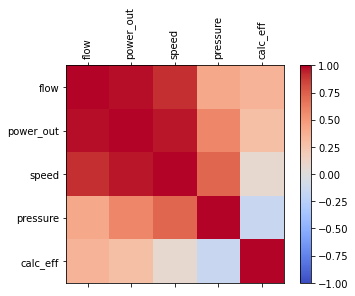

               flow  power_out     speed  pressure  calc_eff
flow       1.000000   0.978173  0.912395  0.414404  0.355139
power_out  0.978173   1.000000  0.967945  0.591005  0.282410
speed      0.912395   0.967945  1.000000  0.718984  0.074894
pressure   0.414404   0.591005  0.718984  1.000000 -0.146426
calc_eff   0.355139   0.282410  0.074894 -0.146426  1.000000


In [ ]:
# Correlation of values
pump5 = pump[pump['pump']==5]

# Select values to correlate and normalize by the max value
sdf = pump5[['flow', 'power_out', 'speed', 'pressure', 'calc_eff']]
#sdf = p5min[['flow', 'power_out', 'speed', 'pressure', 'calc_eff']]
sdf_scaled = sdf/sdf.max()

# Calculate Pearson correlation (or kendall)
corr = sdf.corr('pearson')
#corr = sdf.corr('kenall')

# Figure
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(sdf.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(sdf.columns)
ax.set_yticklabels(sdf.columns)
plt.show()
print(corr)

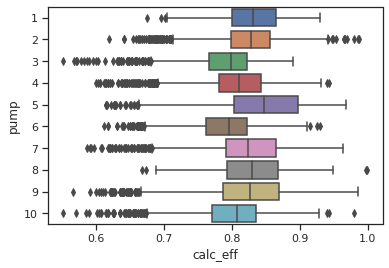

In [ ]:
ax = sns.boxplot(x=pump['calc_eff'], y=pump['pump'], orient="h")
#ax = sns.boxplot(x=p5min['calc_eff'], y=p5min['pump'], orient="h")

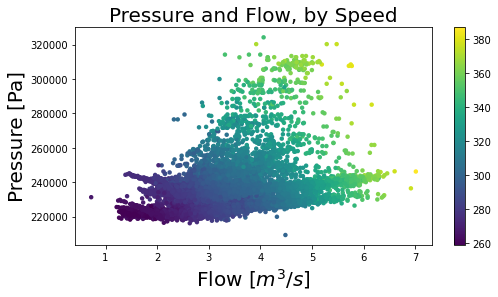

In [5]:
# plot pressure and flow varying with speed
fig, ax = plt.subplots(figsize=(8,4))

sc = ax.scatter(pump['flow'], pump['pressure'], marker='o', s=20, label='Data', c = pump['speed'], edgecolors = 'none')
plt.colorbar(sc)
plt.xlabel('Flow [$m^3/s$]', fontsize=20)
plt.ylabel('Pressure [Pa]', fontsize=20)
plt.title('Pressure and Flow, by Speed', fontsize=20)

plt.show()

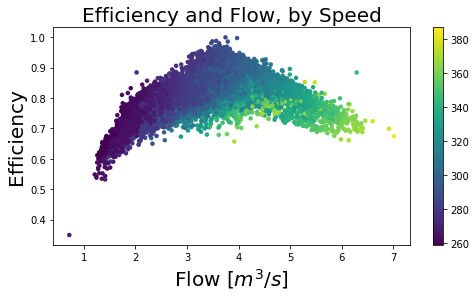

In [6]:
# plot efficiency and flow with speed
fig, ax = plt.subplots(figsize=(8,4))

sc = ax.scatter(pump['flow'], pump['calc_eff'], marker='o', s=20, label='Data', c = pump['speed'], edgecolors = 'none')
plt.colorbar(sc)
plt.xlabel('Flow [$m^3/s$]', fontsize=20)
plt.ylabel('Efficiency', fontsize=20)
plt.title('Efficiency and Flow, by Speed', fontsize=20)

#plt.xlim(1,7)
#plt.ylim(0.6,1)
plt.show()

In [7]:
# TOTAL POWER & YEARLY ENERGY COST #
TP = np.sum(pump['power']) # power in kW
TT, n = pump.shape
YE = TP
elec_2018 = 804930*10**3
elec_cost = 0.1
YEC = YE*elec_cost
print(f'Total power is:    {TP} kWh')
print(f'Total time is:     {TT} hours')
print(f'Yearly energy is:  {YE} kWh')
print(f'Electricity cost:  ${elec_cost}')
print(f'Yearly energy cost:  ${YEC}')
print(f'Percent energy cost: {TP/elec_2018}')

Total power is:    19462984.39069145 kWh
Total time is:     20058 hours
Yearly energy is:  19462984.39069145 kWh
Electricity cost:  $0.1
Yearly energy cost:  $1946298.4390691454
Percent MA energy cost: 0.024179722945711368


# True Weighted Efficiency

*   Pump stats: Calculate true weighted efficiency TWE, average efficiency, time weighted average TWA, the operating time, standard deviation, and total power for the datasets
*   Calculate power savings and percent change in TWE for several scenarios
*   Plot comparisons of TWE for hourly, 5 min etc.


In [13]:
# define efficiency compare function #
def efficiencycompare(df):
  # Takes a dataframe with pump information calculates the true weighted efficiency, the average efficiency, the operating time, and the std deviation, returns the pump_stats
  # Initialize
  TWE =     []   
  avg_eff = []
  TWA =     []
  optime =  []
  stddev =  []
  pwr    =  []
  keys = np.arange(1,11,1)

  # Calculate individual pump TWE by selecting each pump data using .loc[keys]
  for i in keys:
    pp = df[df['pump']==i]
    temp_twe      = np.sum(pp['power_out'])/np.sum(pp['power'])
    temp_avgeff   = np.mean(pp['calc_eff']) 
    temp_twa      = np.sum(pp['calc_eff'])/np.sum(pp['status'])
    temp_op       = np.sum(pp['status'])
    temp_stddev   = np.std(pp['calc_eff'])*100
    temp_pwr      = np.sum(pp['power'])
    
    TWE.append(temp_twe)
    avg_eff.append(temp_avgeff)
    TWA.append(temp_twa)
    optime.append(temp_op)
    stddev.append(temp_stddev)
    pwr.append(temp_pwr)

  # System Calculations
  TWE_all = np.sum(df['power_out'])/np.sum(df['power'])    # System TWE
  sys_avg_eff = np.mean(df['calc_eff'])
  TWA_all = np.sum(df['calc_eff'])/np.sum(df['status'])    # divide the sum of efficiencies by the total time
  op = (optime / np.sum(df['status']))
  pwr_all = np.sum(df['power'])

  #Create TWE dataframe
  pump_stats = pd.DataFrame(list(zip(keys, TWE, avg_eff, TWA, op, stddev, optime, pwr)), columns =['pump', 'TWE', 'avg_eff', 'TWA', 'Op', 'Stddev', 'Optime', 'Pwr']) 
  to_append = ['0', TWE_all, sys_avg_eff, TWA_all, 100, 0, 0, pwr_all]
  TWE_length = len(pump_stats)
  pump_stats.loc[TWE_length] = to_append
  
  return (pump_stats)

In [19]:
# PUMP STATS
pump_stats = efficiencycompare(pump)
print(pump_stats)

p5min_stats = efficiencycompare(p5min)
#print(p5min_stats)

paug = pump[pump['date'].dt.month == 8]
p_aug_stats = efficiencycompare(paug)
#print(p_aug_stats)

#print(pump.dtypes)

   pump       TWE   avg_eff  ...    Stddev  Optime           Pwr
0     1  0.833044  0.832152  ...  4.159122     713  7.282543e+05
1     2  0.826190  0.824903  ...  4.583092    2792  2.820980e+06
2     3  0.794352  0.790741  ...  4.687615    2024  2.088978e+06
3     4  0.813421  0.809732  ...  5.351062    2096  1.984880e+06
4     5  0.846200  0.845529  ...  6.025362    2877  2.736543e+06
5     6  0.791330  0.790047  ...  4.732099    2325  2.277482e+06
6     7  0.824888  0.821979  ...  6.119010    1755  1.597381e+06
7     8  0.830518  0.829125  ...  4.892400    1550  1.544367e+06
8     9  0.827894  0.824283  ...  6.416830    2008  1.845984e+06
9    10  0.804985  0.799036  ...  5.359244    1911  1.834351e+06
10    0  0.818859  0.816587  ...  0.000000       0  1.945920e+07

[11 rows x 8 columns]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


In [10]:
# Paper stats
# 1 -- calculate the power savings from the pump 9 maintenance
pump9powersavings = (1-(0.788/0.849))*2.8*10**6
print('Pump 9 maintenance power savings: ', pump9powersavings*.1)

# 2 -- calculate power savings from operating at 84.6 rather than 81.9 TWE
pumpsyspowersavings = (1-(0.819/0.849))*1.9459*10**7
print('Power savings from system improvement: ', pumpsyspowersavings*.1)
print('   Percent improvement ', (0.849-0.819)*100)

# 3 -- calculate power savings from low flow operational change
pumpsyspowersavings = (1-(0.83/0.866))*1.9459*10**7
print('Power savings low flow operational change ', pumpsyspowersavings*.1)
print('   Percent improvement ', (0.866-0.83)*100)

Pump 9 maintenance power savings:  20117.78563015311
Power savings from system improvement  68759.71731448769
   Percent improvement  3.0000000000000027
Power savings low flow operational change  80891.91685912258
   Percent improvement  3.600000000000003


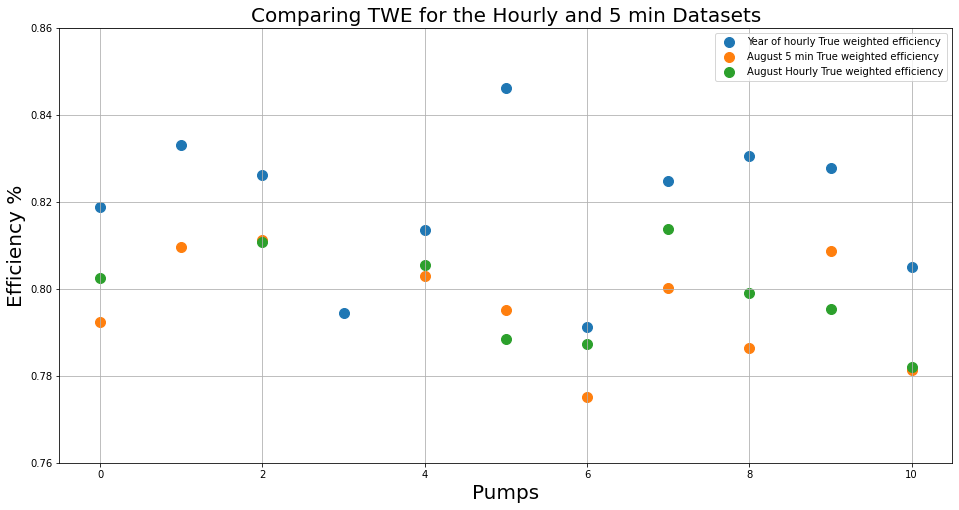

In [22]:
# Comparing TWE for the Hourly and 5 min datasets
fig = plt.figure(figsize=(16,8))
plt.scatter(pump_stats['pump'], pump_stats['TWE'], marker='o', s=100, label='Year of hourly True weighted efficiency')
plt.scatter(p5min_stats['pump'], p5min_stats['TWE'], marker='o', s=100, label='August 5 min True weighted efficiency')
plt.scatter(p_aug_stats['pump'], p_aug_stats['TWE'], marker='o', s=100, label='August Hourly True weighted efficiency')

plt.title('Comparing TWE for the Hourly and 5 min Datasets', fontsize = 20)
plt.xlabel('Pumps', fontsize = 20)
plt.ylabel('Efficiency %', fontsize = 20)
plt.legend()
plt.ylim(0.76,0.86)
plt.grid()
plt.show()

In [ ]:
# Comparing TWE and average efficiency for all pumps 5min
#fig = plt.figure(figsize=(16,8))
#plt.scatter(p5min_stats['pump'], p5min_stats['TWE'], marker='o', s=150, label='5min True weighted efficiency')
#plt.scatter(p5min_stats['pump'], p5min_stats['TWA'], marker='o', s=150, label='5min Time weighted average')

# Could also compare pump TWE for the hourly and 5 min datasets
#plt.scatter(pump_stats['pump'], pump_stats['TWE'], marker='o', s=150, label='Hourly True weighted efficiency')
#plt.scatter(p5min_stats['pump'], p5min_stats['TWE'], marker='o', s=150, label='5 min True weighted efficiency')

#plt.title('Comparing TWE and average efficiency for all pumps 5min', fontsize = 20)
#plt.xlabel('Pumps', fontsize = 20)
#plt.ylabel('Efficiency %', fontsize = 20)
#plt.legend()
#plt.ylim(0.76,0.82)
#plt.grid()
#plt.show()

# Violin plots comparing pump operation

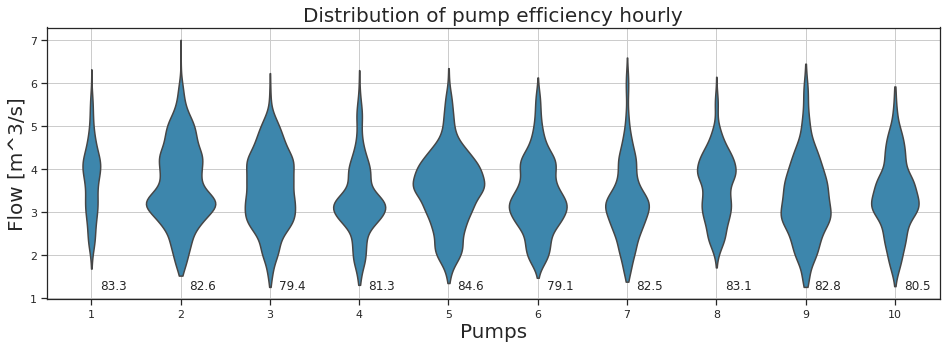

In [ ]:
# TWE for pump 5
vTWE = pump_stats.iloc[0:10]
vTWE5 = p5min_stats.iloc[0:10]
keys = np.arange(1,11,1)
#print(vTWE)

fig, ax = plt.subplots(figsize=(16,5))
#order = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']

sns.violinplot(x='pump', y='flow', split=True, inner=None, data=pump, color='#2b8cbe', order=keys,  scale='count', cut=0)
plt.xlabel('Pumps', fontsize=20)
plt.ylabel('Flow [m^3/s]', fontsize=20)
plt.title('Distribution of pump efficiency hourly', fontsize=20)

yposlist = np.ones(len(vTWE['TWE']))*0.6
xposlist = range(10)
stringlist = vTWE['TWE']

for xpos,ypos,string in zip(xposlist,yposlist,stringlist):
    ax.text(xpos+0.1, ypos+0.6, round(string*100,1) )

#plt.ylim(0.6,1)
plt.grid(True)
plt.show()
# notes https://seaborn.pydata.org/generated/seaborn.violinplot.html

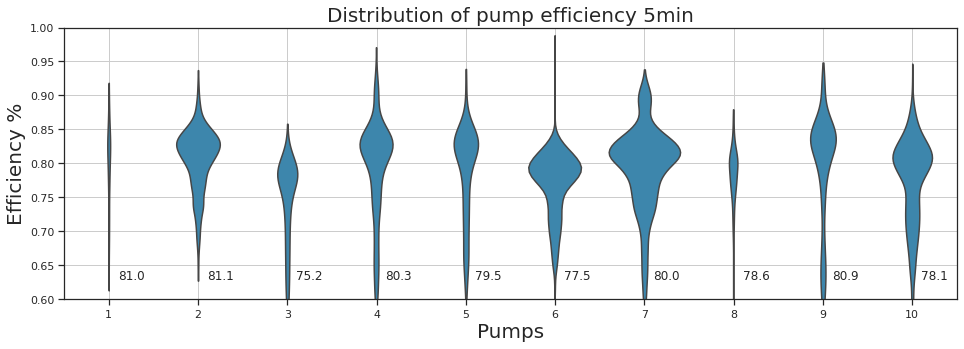

In [ ]:
fig, ax = plt.subplots(figsize=(16,5))
#order = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']

sns.violinplot(x='pump', y='calc_eff', split=True, inner=None, data=p5min, color='#2b8cbe', order=keys,  scale='count', cut=0)
plt.xlabel('Pumps', fontsize=20)
plt.ylabel('Efficiency %', fontsize=20)
plt.title('Distribution of pump efficiency 5min', fontsize=20)

yposlist = np.ones(len(vTWE5['TWE']))*0.6
xposlist = range(10)
stringlist = vTWE5['TWE']

for xpos,ypos,string in zip(xposlist,yposlist,stringlist):
    ax.text(xpos+0.1, ypos+0.03, round(string*100,1) )

plt.ylim(0.6,1)
plt.grid(True)
plt.show()

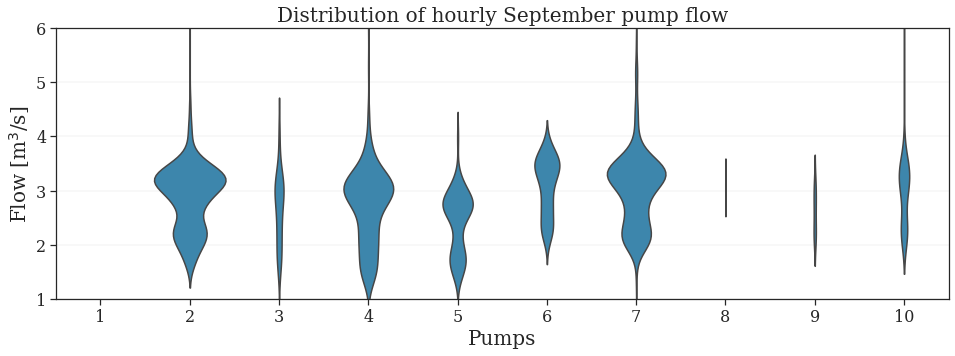

In [ ]:
sns.set(style="ticks", font='serif')
keys = np.arange(1,11,1)
fig, ax = plt.subplots(figsize=(16,5))

ax  = sns.violinplot(x='pump', y='flow',  split=True, inner=None, data= paug, color='#2b8cbe', order=keys,  scale='count')

plt.xlabel('Pumps', fontsize=20)
plt.ylabel('Flow [m$^3$/s]', fontsize=20)
plt.title('Distribution of hourly September pump flow', fontsize=20)
plt.ylim(1,6)
ax.yaxis.grid(True, color='lightgrey', linewidth=0.3)
ax.tick_params(axis='both', which='major', labelsize=16)

plt.show()

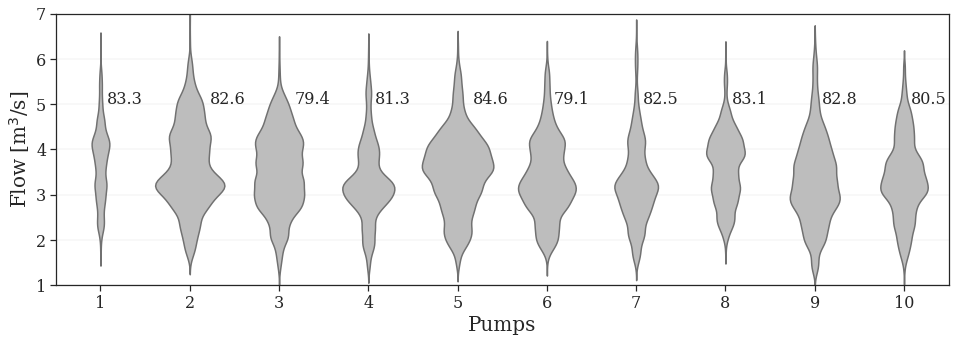

In [ ]:

fig, ax = plt.subplots(figsize=(16,5))

yvar = 'flow'
ax = sns.violinplot(x='pump', y=yvar, split=True, inner=None, data=pump, color='#bdbdbd', order=keys,  scale='count', bw=0.15)

yposlist = np.ones(len(vTWE['TWE']))*5 # min(df[yvar])
xposlist = [0, 1.15, 2.1, 3, 4.1, 5, 6, 7, 8, 9]
stringlist = vTWE['TWE']

for xpos,ypos,string in zip(xposlist,yposlist,stringlist):
    ax.text(xpos+0.075, ypos, round(string*100,1), fontsize=16 )

plt.xlabel('Pumps', fontsize=20)
plt.ylabel('Flow [m$^3$/s]', fontsize=20)
#plt.title('Distribution of hourly pump flow annotated with TWE', fontsize=20)
plt.ylim(1,7)
ax.yaxis.grid(True, color='lightgrey', linewidth=0.3)
ax.tick_params(axis='both', which='major', labelsize=16)

plt.show()

In [ ]:
print(p5min.dtypes)
#p5min['min'] = np.datetime64.minute()
phr = p5min[(p5min['date'].dt.minute == 0)&(p5min['date'].dt.month == 8)]
print(phr.shape)

time                        object
status                       int64
pump                         int64
speed                      float64
elevation                  float64
flow                       float64
power                      float64
pressure                   float64
dynamic_pressure           float64
total_pressure             float64
power_out                  float64
calc_eff                   float64
date                datetime64[ns]
dtype: object
(303, 13)


In [ ]:
phr.head()

time  status  ...  calc_eff                date
287  2020-08-01 00:00:00.000       1  ...  0.848969 2020-08-01 00:00:00
299  2020-08-01 01:00:00.000       1  ...  0.868883 2020-08-01 01:00:00
311  2020-08-01 02:00:00.000       1  ...  0.823266 2020-08-01 02:00:00
323  2020-08-01 03:00:00.000       1  ...  0.819423 2020-08-01 03:00:00
335  2020-08-01 04:00:00.000       1  ...  0.735978 2020-08-01 04:00:00

[5 rows x 13 columns]

In [ ]:
#phra = phra.append(phr)
print(phra.shape)
print(paug.shape)
#phra should be 3636, there are 12, 5 min increments in each hour

(3636, 13)
(1234, 15)


In [ ]:
paug_app = paug_app.append(paug)
print(paug_app.shape)
# Should be 14808

(14808, 15)


In [ ]:
p5min_aug = p5min[p5min['date'].dt.month == 8]
print(p5min_aug.shape)
print(p5min.shape)

(14833, 13)
(32440, 13)


In [ ]:
# Select values from the year and month data sets, label and combine  
#yearflow = phr[['pump','flow']]
yearflow = paug_app[['pump','flow']]
yearflow.insert(2, 'label', 1)
#yearflow.head()
monthflow = p5min_aug[['pump','flow']]
monthflow.insert(2, 'label', 2)

stack = pd.concat([yearflow, monthflow], axis=0)
stack.head(20)

pump      flow  label
3139     2  3.000884      1
3140     2  2.734317      1
3141     2  2.290450      1
3142     2  2.099025      1
3143     2  1.793348      1
3144     2  1.697124      1
3145     2  1.592828      1
3146     2  1.627321      1
3147     2  1.882587      1
3148     2  2.669358      1
3149     2  2.815569      1
3150     2  2.936534      1
3151     2  3.178216      1
3152     2  3.332120      1
3153     2  3.180520      1
3154     2  2.939047      1
3155     2  3.014356      1
3156     2  2.998499      1
3157     2  2.790406      1
3158     2  2.987640      1

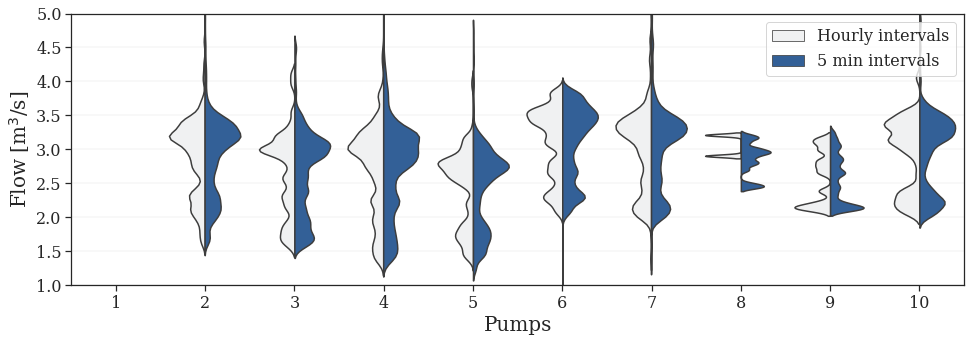

In [ ]:
# FIGURE USED IN PAPER
sns.set(style="ticks", font='serif')
fig, ax = plt.subplots(figsize=(16,5))

yvar = 'flow'
ax = sns.violinplot(x='pump', y=yvar, split=True, inner=None, data= stack, hue='label', color='#225ea8', order=keys,  scale='count', bw=0.12) # or area, count, width

#yposlist = np.ones(len(vTWE5['TWE']))*5 # min(df[yvar])
#xposlist = [0, 1.15, 2.1, 3, 4.1, 5, 6, 7, 8, 9]
#stringlist = vTWE5['TWE']

#for xpos,ypos,string in zip(xposlist,yposlist,stringlist):
#    ax.text(xpos+0.075, ypos, round(string*100,1), fontsize=16 )

plt.xlabel('Pumps', fontsize=20)
plt.ylabel('Flow [m$^3$/s]', fontsize=20)
#plt.title('Distribution of September flow for hourly and 5 min dataset', fontsize=20)
plt.ylim(1,5)
ax.yaxis.grid(True, color='lightgrey', linewidth=0.3)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend(['Hourly intervals', '5 min intervals'], fontsize=16)

plt.show()

In [ ]:
print(len(pump['flow']))

20051


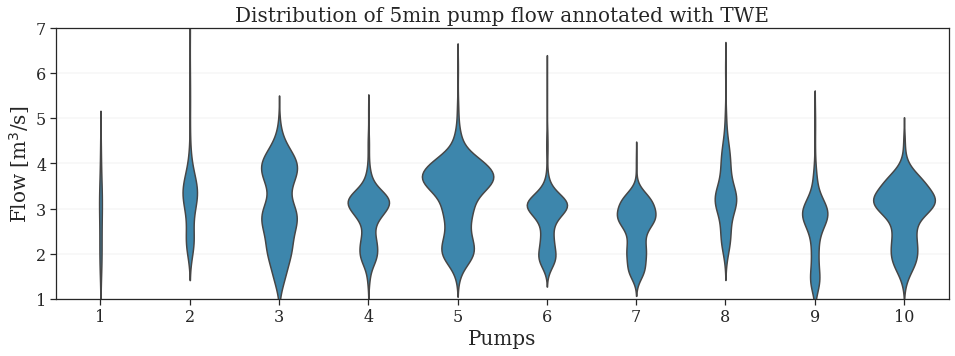

In [ ]:
fig, ax = plt.subplots(figsize=(16,5))

ax = sns.violinplot(x='pump', y='flow', split=True, inner=None, data=psept, color='#2b8cbe', order=keys,  scale='count')

plt.xlabel('Pumps', fontsize=20)
plt.ylabel('Flow [m$^3$/s]', fontsize=20)
plt.title('Distribution of 5min pump flow annotated with TWE', fontsize=20)
plt.ylim(1,7)
ax.yaxis.grid(True, color='lightgrey', linewidth=0.3)
ax.tick_params(axis='both', which='major', labelsize=16)

plt.show()

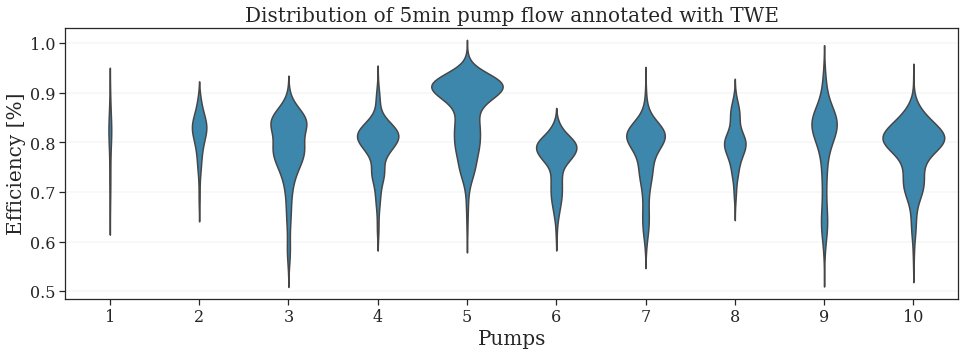

In [ ]:
fig, ax = plt.subplots(figsize=(16,5))

ax = sns.violinplot(x='pump', y='calc_eff', split=True, inner=None, data=psept, color='#2b8cbe', order=keys,  scale='count')

plt.xlabel('Pumps', fontsize=20)
plt.ylabel('Efficiency [%]', fontsize=20)
plt.title('Distribution of 5min pump flow annotated with TWE', fontsize=20)
ax.yaxis.grid(True, color='lightgrey', linewidth=0.3)
ax.tick_params(axis='both', which='major', labelsize=16)

plt.show()

# Time series analysis
*     Calculate the average efficiency by month
*     Plot monthly efficiency as a percent of max efficiency
*     Plot efficiency and flow by day and speed

In [25]:
# Calculate average efficiency by month
month_avg_eff = []
month_str     = ['Jan', 'Feb', 'March', 'April', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']

for i in range(1,13):
  temp = pump.loc[pump['date'].dt.month==i]
  eff  = temp['calc_eff'].mean()
  month_avg_eff.append(eff)

month_stats = pd.DataFrame(list(zip(month_str, month_avg_eff)), columns =['Month', 'Avg Eff']) 
print (month_stats)
#month_stats.describe()

#max_scale = pump['calc_eff'].max()
#max_scale = month_stats['Avg Eff'].max()
#month_stats['Avg Eff'] = month_stats['Avg Eff']/max_scale
#print(max_scale)
#print (month_stats)

    Month   Avg Eff
0     Jan  0.836748
1     Feb  0.826916
2   March  0.821323
3   April  0.811002
4     May  0.821032
5    June  0.801664
6    July  0.814393
7     Aug  0.796653
8    Sept  0.800529
9     Oct  0.816856
10    Nov  0.834136
11    Dec  0.822757


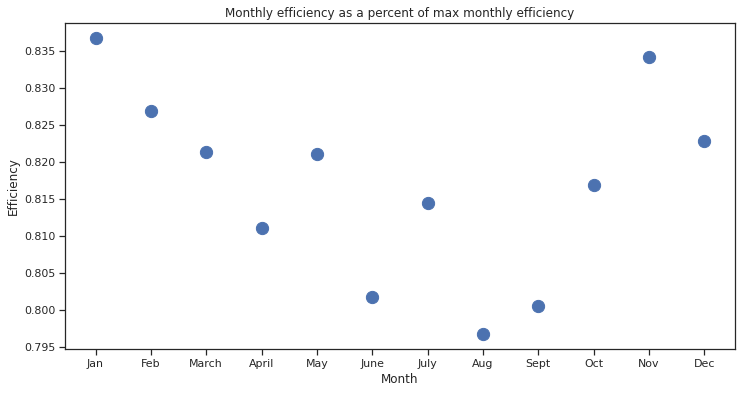

In [26]:
# Monthly efficiency as a percent of max monthly efficiency
fig, ax = plt.subplots(figsize=(12,6))
ax = plt.scatter(month_stats['Month'], month_stats['Avg Eff'], marker='o', s=150, label='Monthly efficiency as a percent of max month efficiency')
plt.title('Monthly efficiency as a percent of max monthly efficiency')
plt.ylabel('Efficiency')
plt.xlabel('Month')
plt.show()

In [ ]:
pump['weekday'] = pump['date'].dt.day_name()
pump['hour'] = pump['date'].dt.hour
#pump.head()

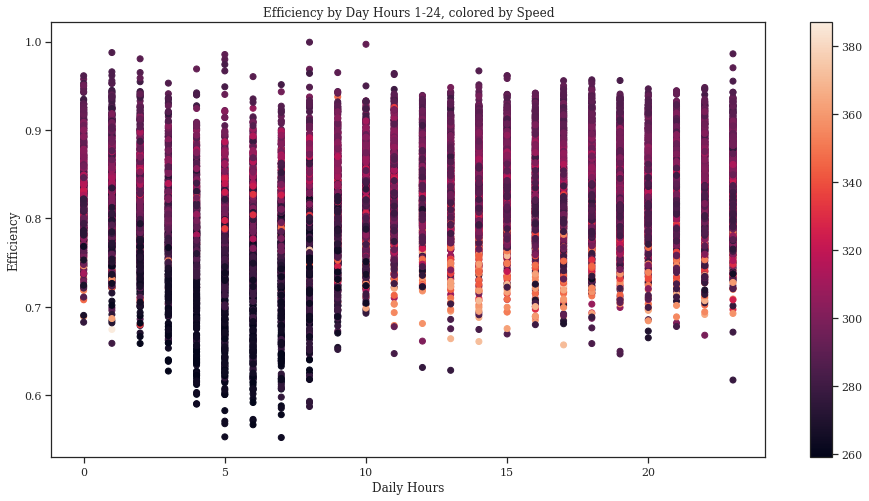

In [ ]:
fig = plt.figure(figsize=(16,8))
sc = plt.scatter(pump['hour'], pump['calc_eff'], c = pump['speed'])
plt.colorbar(sc)
plt.xlabel('Daily Hours')
plt.ylabel('Efficiency')
plt.title('Efficiency by Day Hours 1-24, colored by Speed')
plt.show()

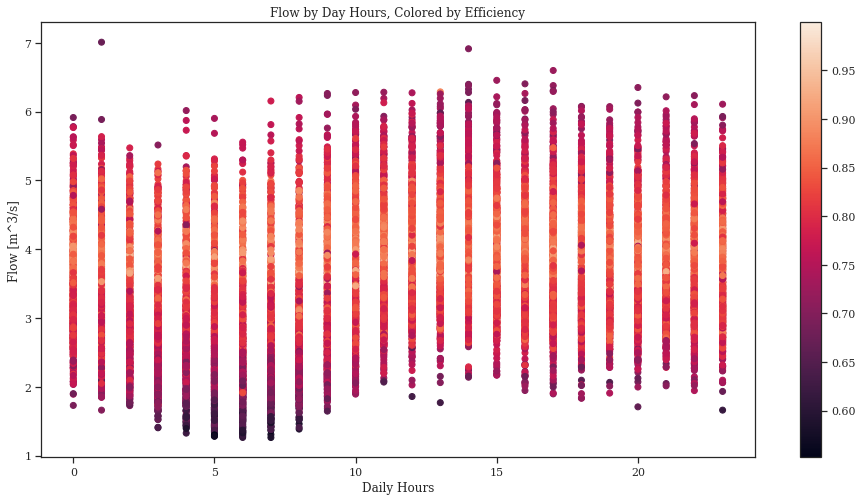

In [ ]:
fig = plt.figure(figsize=(16,8))
sc = plt.scatter(pump['hour'], pump['flow'], c = pump['calc_eff'])
plt.colorbar(sc)
plt.xlabel('Daily Hours')
plt.ylabel('Flow [m^3/s]')
plt.title('Flow by Day Hours, Colored by Efficiency')
plt.show()

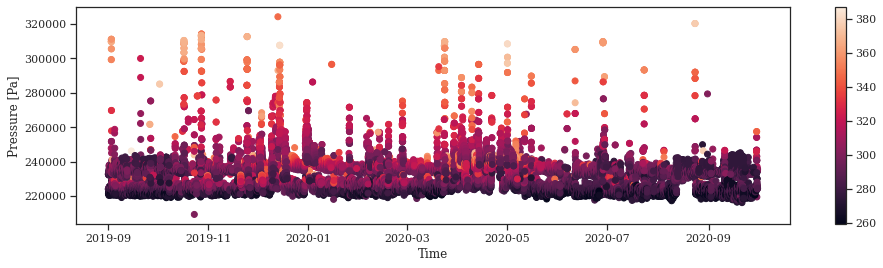

In [ ]:
# Time series plot of pressure, power, flow, speed etc
fig = plt.figure(figsize=(16,4))
sc = plt.scatter(pump['date'], pump['pressure'], c = pump['speed'])

plt.colorbar(sc)
plt.xlabel('Time')
plt.ylabel('Pressure [Pa]')
#plt.setp(ax.get_xticklabels(), rotation=45)
plt.show()

In [ ]:
# Select a subset of the data to plot, first sort by time
sort = pump.sort_values(by='time')
temp = sort.iloc[500:1600]

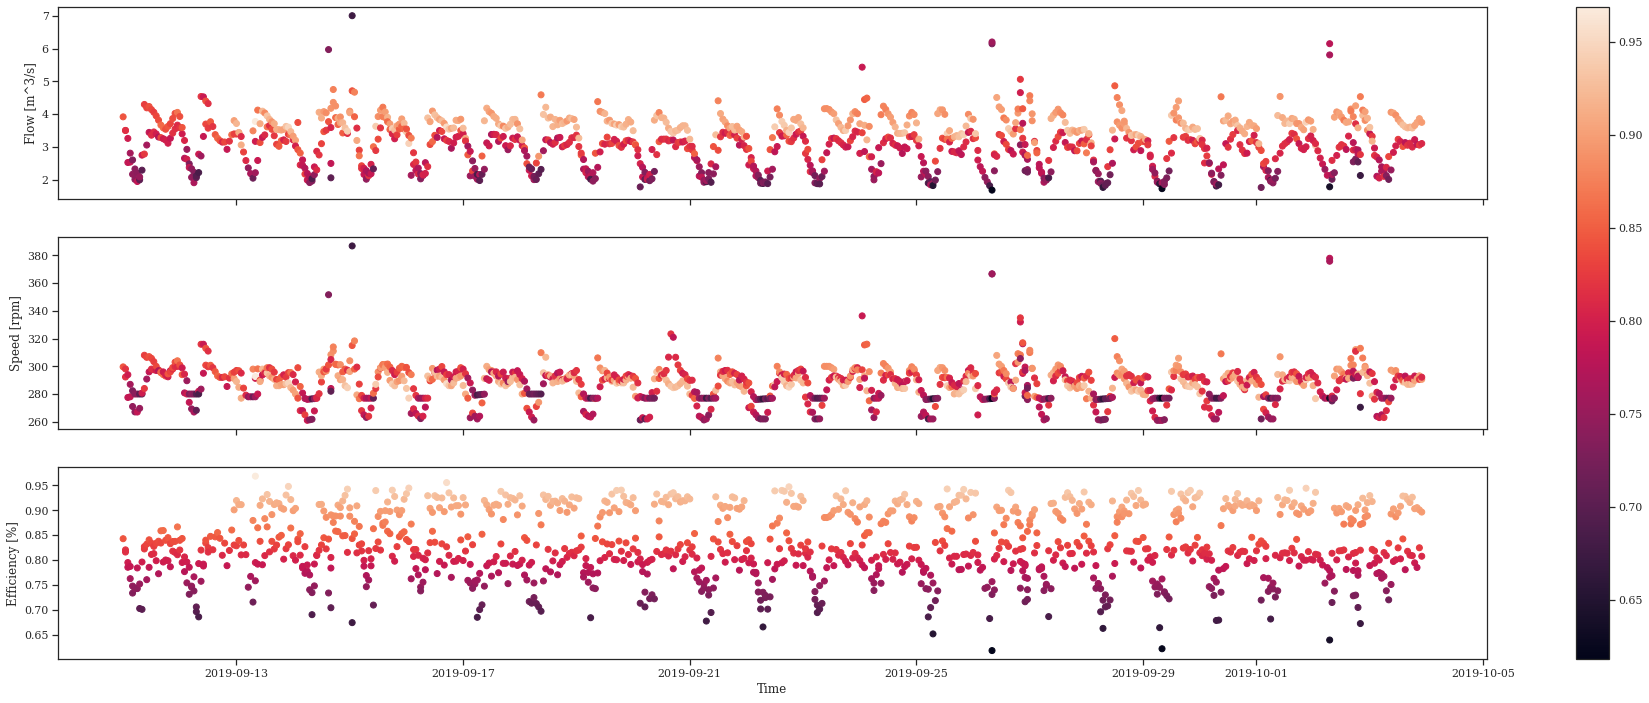

In [ ]:
# Paper Figure
fig, axs = plt.subplots(5,1, sharex=True, figsize=(32,12))
sc = axs[0].scatter(temp['date'], temp['flow'], c = temp['calc_eff'])
axs[1].scatter(temp['date'], temp['speed'], c = temp['calc_eff'])
axs[2].scatter(temp['date'], temp['calc_eff'], c = temp['calc_eff'])
axs[3].scatter(temp['date'], temp['pressure'], c = temp['calc_eff'])
axs[4].scatter(temp['date'], temp['power']/temp['flow'], c= temp['calc_eff'])

fig.colorbar(sc, ax=axs)

axs[2].set_xlabel('Time')
axs[0].set_ylabel('Flow [m^3/s]')
axs[1].set_ylabel('Speed [rpm]')
axs[2].set_ylabel('Efficiency [%]')
axs[3].set_ylabel('Pressure [kPa]')
axs[4].set_ylabel('Power per Flow [kW/m^3/s]')


plt.show()

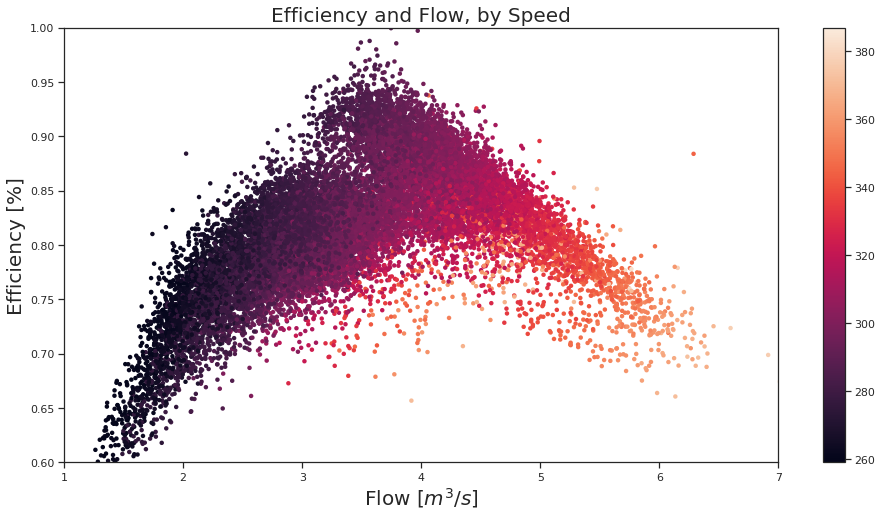

In [27]:
fig, ax = plt.subplots(figsize=(16,8))

sc = ax.scatter(pump['flow'], pump['calc_eff'], marker='o', s=20, label='Data', c = pump['speed'], edgecolors = 'none')
#ax.scatter(pump_all['flow'], pump_all['calc_eff'], s=20, label='Data', color='#00b3b3')
plt.colorbar(sc)
plt.xlabel('Flow [$m^3/s$]', fontsize=20)
plt.ylabel('Efficiency [%]', fontsize=20)
plt.title('Efficiency and Flow, by Speed', fontsize=20)
plt.xlim(1,7)
plt.ylim(0.6,1)
plt.show()

# Low flow savings

What is the potential savings for running a smaller pump or running fewer pumps at lower flows?

Outline:

1.   Import dataset with all the pumps as columns and a single row for each datetime, saved by cleaning procedure
2.   Make column that is the sum of flows for all the pumps for each datetime
3.   Make new dataframe with only one flow per timestep , and a pressure. Subsitute the total flow for flows less than 2.5 $m^3/s$
4.   Calculate the dynamic pressure head from the increased flow and add to pressure
5.   Calculate omega using the coefficients \& equation with flow and pressure
6.   Using omega, flow and pressure calculate the new input power for the points
7.   Calculate hydraulic $Power_h=(Q*P)$
8.   Calculate efficiency as $P_{hydraulic}/P_{input}$
9.  Calculate TWE as sum of the hydraulic power / sum of input power and compare to dataframe before and after.

Checked percentage of points are less than 2.5 $m^3/s$ for the year-hourly and the month-5min datasets
How often is only 1 pump running? For a datetime, sum the pump status' and check status >=2 or ==1 or ==0.




In [ ]:
# Step 1: Import dataset
plf = pd.read_csv('/content/drive/My Drive/[*] Adaptive Hydraulics/MWRA/plfcleaned.csv')
plf['date'] = pd.to_datetime(plf['time'])
plf = plf.drop(labels = ['time'], axis=1)
plf.head()

pump       speed      flow  ...       pressure  calc_eff                    date
0     1  291.000000  3.449922  ...  222488.473975  0.816925 2020-09-02 14:04:59.997
1     1  291.462799  3.513123  ...  223309.940990  0.844344 2020-09-02 14:09:59.997
2     1  293.763855  3.775190  ...  222244.415268  0.868832 2020-09-02 14:14:59.997
3     1  293.147858  3.803162  ...  221170.336460  0.871039 2020-09-02 14:19:59.997
4     1  291.173492  3.607144  ...  221427.774615  0.881930 2020-09-02 14:24:59.997

[5 rows x 8 columns]

In [ ]:
# Split plf: take all the tot_flow <= 2.5 and put into lfb and keep plf with speed, power, calc_eff
lfb = plf.loc[plf['tot_flow'] <= 5]
nfb = plf.loc[plf['tot_flow']  > 5]

# Drop half of the duplicate points
lfb = lfb.drop_duplicates(subset='date')
print(len(lfb))

# Flow equal to total flow
lfb['flow'] = lfb['tot_flow']


5733


In [ ]:
# Now calculate the new speed and efficiency
# Set the coefficients
C = [-0.37942117,  7.80555305, -7.27090982,  6.40822911, -5.96349589,  0.18864433]
H = [ 0.71716686, -1.58570205, -0.55721749, -0.36122178,  3.50378147,  3.20966408, -1.54526742, -0.76805227, -0.95895611, -0.72994597]

# Normalize the data
pwrnorm = max(pump['power'])
snorm = max(pump['speed'])
qnorm = max(pump['flow'])
pnorm = max(pump['pressure']) 

lfb['flown'] = lfb['flow']/qnorm
lfb['pressuren'] = lfb['pressure']/pnorm

lfb.head()

pump       speed      flow  ...                    date     flown  pressuren
157     1  264.991455  4.947130  ... 2020-09-03 03:09:59.997  0.705705   0.676721
158     1  264.525238  4.943814  ... 2020-09-03 03:14:59.997  0.705232   0.676598
159     1  264.059052  4.878894  ... 2020-09-03 03:19:59.997  0.695971   0.675698
160     1  264.000000  4.813974  ... 2020-09-03 03:24:59.997  0.686710   0.676691
161     1  264.000000  4.798039  ... 2020-09-03 03:29:59.997  0.684437   0.678102

[5 rows x 10 columns]

In [ ]:
# Normalize lfb and then unnormalize using the max values below
# Qlfb = C[0] + C[1]*UU + C[2]*P + C[3]*UU*P + C[4]*UU**2 + C[5]*P**2
# Solve for omega

ffb = lfb

# Calculate dynamic pressure
diam = 48*0.0254 # [m]
pipeA = np.pi*(diam/2)**2

cp = 2*500/pipeA**2
ffb['dP'] = (cp*(ffb['flow']**2 - (ffb['flow']/2)**2))/pnorm # Qt**2 - Qs**2
ffb['pressurendp'] = ffb['pressuren']+ffb['dP']

# Calculate coefficients for the quadratic formula solution for speed
a = C[4]
b = C[1] + C[3]*ffb['pressurendp']
c = -ffb['flown'] + C[5]*ffb['pressurendp']**2 + C[0] + C[2]*ffb['pressurendp']

# Check for negative z values (shouldn't be any)
z = b ** 2 - (4 * a * c)
print (len([_ for _ in z if _ < 0]))

ffb['neg_b'] = -b
ffb['b2']    = b**2
ffb['4ac']   = 4*a*c
ffb['2a']    = np.ones(len(b))*2*a
ffb['z']     = ffb['b2']-ffb['4ac']

ffb = ffb.drop(ffb[ffb['z']<0].index) # Can't take sqrt of -s

# use omega 1 solution to the quadratic formula
ffb['o1'] = (ffb['neg_b']+np.sqrt(ffb['z']))/ffb['2a']
ffb['o2'] = (ffb['neg_b']-np.sqrt(ffb['z']))/ffb['2a']

# calculate power out electrical and hydraulic
ffb['powern'] =  H[0] + H[1]*ffb.o1 + H[2]*ffb.pressurendp + H[3]*ffb.flown + H[4]*ffb.o1*ffb.pressurendp + H[5]*ffb.o1*ffb.flown + H[6]*ffb.pressurendp*ffb.flown + H[7]*ffb.o1**2 + H[8]*ffb.pressurendp**2 + H[9]*ffb.flown**2
ffb['powerh'] =  ffb.flown*ffb.pressurendp


0


In [ ]:
ffb.head()

pump       speed      flow  ...        o2    powern    powerh
157     1  264.991455  4.947130  ...  1.242774  0.559291  0.506883
158     1  264.525238  4.943814  ...  1.242898  0.558614  0.506417
159     1  264.059052  4.878894  ...  1.245901  0.547333  0.498387
160     1  264.000000  4.813974  ...  1.249594  0.538547  0.491704
161     1  264.000000  4.798039  ...  1.250961  0.537772  0.490864

[5 rows x 21 columns]

In [ ]:
# Unnormalize the data
ffb['flow']      = ffb['flown']*qnorm
ffb['pressure']  = ffb['pressurendp']*pnorm
ffb['power_un']  = ffb['powern']*pwrnorm*1000
ffb['powerh_un'] = ffb['powerh']*qnorm*pnorm
ffb['eff_un']    = ffb['powerh_un']/ffb['power_un']
ffb['eff']       = ffb['powerh']/ffb['powern']


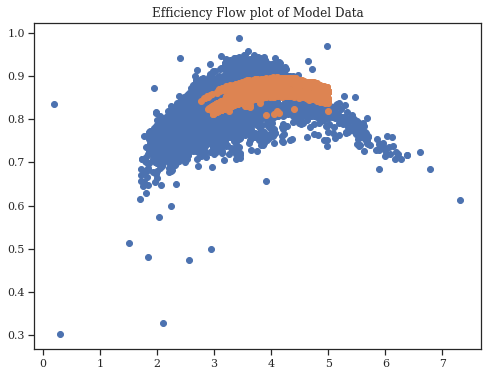

In [ ]:
# Plot results, blue is the normal flow, orange is the calculated low flow points
fig = plt.subplots(figsize=(8,6))
plt.plot(nfb['flow'], nfb['calc_eff'], 'o')
plt.plot(ffb['flow'], ffb['eff_un'], 'o')
#plt.plot(ffb['flow'], ffb['efflin'], 'o')

plt.title('Efficiency Flow plot of Model Data')
plt.show()

In [ ]:
# Calculate TWE
# Set nfb & ffb for stacking
nfb['power'] = nfb['power']*1000

ffbstack = ffb[['pump', 'speed', 'flow','power_un', 'tot_flow', 'pressure', 'eff_un', 'date']]
ffbstack.columns=['pump', 'speed', 'flow', 'power', 'tot_flow', 'pressure', 'calc_eff', 'date']
ffbstack.head()

# Stack / recombine datasets
td = pd.concat([nfb, ffbstack])
td.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


pump       speed      flow  ...       pressure  calc_eff                    date
0     1  291.000000  3.449922  ...  222488.473975  0.816925 2020-09-02 14:04:59.997
1     1  291.462799  3.513123  ...  223309.940990  0.844344 2020-09-02 14:09:59.997
2     1  293.763855  3.775190  ...  222244.415268  0.868832 2020-09-02 14:14:59.997
3     1  293.147858  3.803162  ...  221170.336460  0.871039 2020-09-02 14:19:59.997
4     1  291.173492  3.607144  ...  221427.774615  0.881930 2020-09-02 14:24:59.997

[5 rows x 8 columns]

In [ ]:
# Calculate specific energy, energy intensity kWh / m^3 average for the old to new system

# Calculate true weighted efficiency
TWE_plf      = np.sum(plf['flow']*plf['pressure'])/np.sum(plf['power']*1000)
TWElf        = np.sum(ffb['flow']*ffb['pressure'])/np.sum(ffb['power_un'])
TWEtot       = np.sum(td['flow']*td['pressure'])/np.sum(td['power'])

print('TWE original: ', TWE_plf)
print('TWE low flow: ', TWElf)
print('TWE new     : ', TWEtot)
print('TWE improvement: ', TWEtot-TWE_plf)


TWE original:  0.7924219534359183
TWE low flow:  0.8664707946020246
TWE new     :  0.8295792032095693
TWE improvement:  0.03715724977365109


In [ ]:
# Calculate specific energy
SE_plf = np.sum(plf['power'])/np.sum(plf['flow']*5*60)
SE_new = np.sum(td['power']/1000)/np.sum(td['flow']*5*60)
print(SE_plf, SE_new)
print('SE improvement : ', SE_plf-SE_new)

0.9550577957625235 0.9213186593240736
SE improvement :  0.033739136438449835


In [ ]:
# How much of the flow is less than 2.5 m^3/s?
lowflow        = pump[pump['flow']<2.5]
nf_subset      = pump[(pump['flow']>=2.5) & (pump['flow']<3)]
normalflow     = pump[(pump['flow']>=3.0) & (pump['flow']<=5)]
highflow       = pump[pump['flow']>5]

total_hrs      = len(pump['flow'])
lowflow_hrs    = len(lowflow['flow'])
nfsubset_hrs   = len(nf_subset['flow'])
normalflow_hrs = len(normalflow['flow'])
highflow_hrs   = len(highflow['flow'])

lf_avgeff      = np.mean(lowflow['calc_eff'])
nfsub_avgeff   = np.mean(nf_subset['calc_eff'])
nf_avgeff      = np.mean(normalflow['calc_eff'])
hf_avgeff      = np.mean(highflow['calc_eff'])

print('Percent low flow : ', lowflow_hrs/total_hrs, 'LF eff ', lf_avgeff)
print('Percent high flow : ', highflow_hrs/total_hrs, 'HF eff', hf_avgeff)
print('Percent normal flow : ', normalflow_hrs/total_hrs, 'NF eff ', nf_avgeff)
#print('2.5 - 3 subset ', nfsubset_hrs/total_hrs, 'NFS eff', nfsub_avgeff)


# This shows that the low flow region is significantly less efficient than the median flow. But what about Power / unit of flow?
# Are there energy savings by running at a lower flow even if its less efficient?
# print('Total Hrs', total_hrs, 'Sum hrs ', lowflow_hrs+highflow_hrs+normalflow_hrs+nfsubset_hrs)


# If the low flow region was operated efficiently, either through a smaller pump or by running 1 pump rather than 2:
tot_eff = np.mean(pump['calc_eff'])
upd_eff = ((lowflow_hrs/total_hrs)+(normalflow_hrs/total_hrs))*nf_avgeff + (highflow_hrs/total_hrs)*hf_avgeff + (nfsubset_hrs/total_hrs)*nf_avgeff
#upd_eff = ((lowflow_hrs/total_hrs)+(normalflow_hrs/total_hrs))*nf_avgeff + (highflow_hrs/total_hrs)*hf_avgeff
print('Original Eff', tot_eff)
print('Updated Eff', upd_eff)
print('Efficiency improvement ', upd_eff - tot_eff)


Percent low flow :  0.14094060146626103 LF eff  0.7379570080566371
Percent high flow :  0.05196748291855768 HF eff 0.7758801050617599
Percent normal flow :  0.6366764749887787 NF eff  0.8422163889876529
Original Eff 0.8165871975096649
Updated Eff 0.8387690592858535
Efficiency improvement  0.02218186177618864


In [ ]:
lowflow        = p5min[p5min['flow']<2.5]
total_hrs      = len(p5min['flow'])
lowflow_hrs    = len(lowflow['flow'])

lf_avgeff      = np.mean(lowflow['calc_eff'])

print('Percent low flow : ', lowflow_hrs/total_hrs, 'LF eff ', lf_avgeff)


Percent low flow :  0.3284833538840937 LF eff  0.7158393682007582


# Pump 9 maintenance

In [ ]:
from dateutil.parser import parse

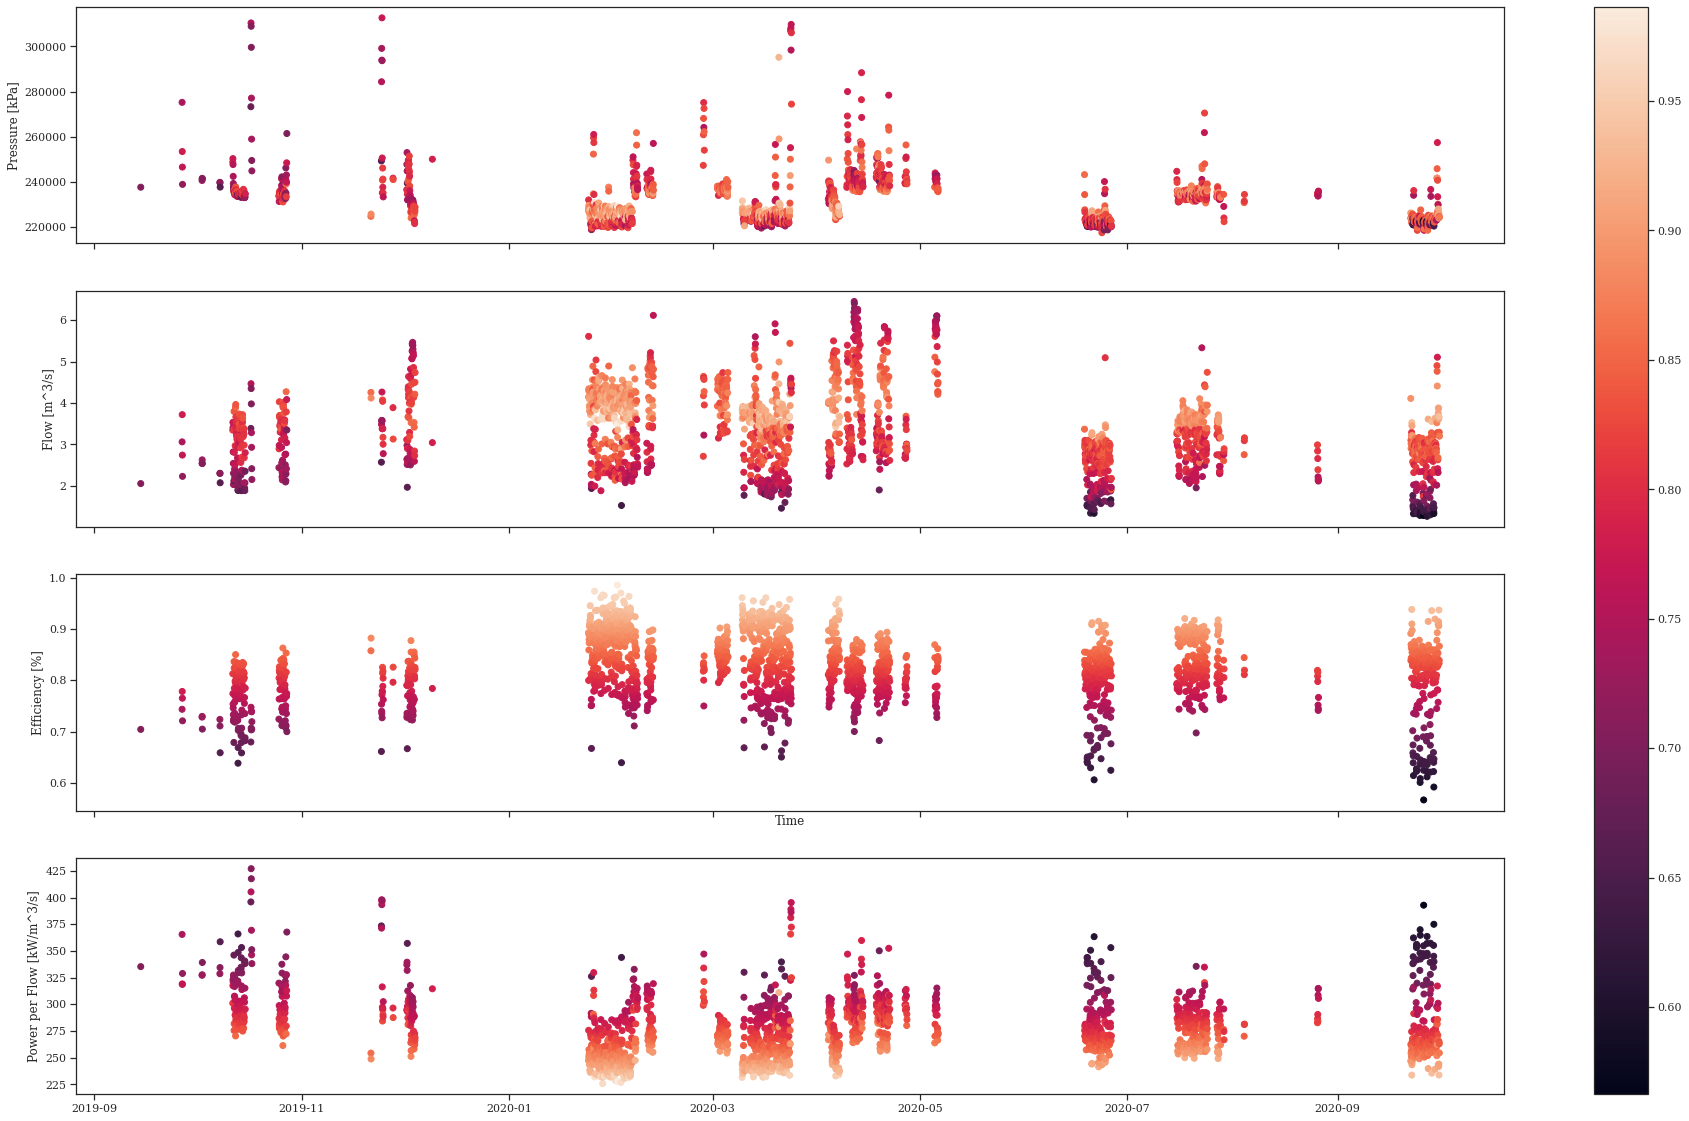

In [ ]:
pump9 = pump[pump['pump']==9]
temp = pump9

fig, axs = plt.subplots(4,1, sharex=True, figsize=(32,20))
sc = axs[0].scatter(temp['date'], temp['pressure'], c = temp['calc_eff'])
axs[1].scatter(temp['date'], temp['flow'], c = temp['calc_eff'])
axs[2].scatter(temp['date'], temp['calc_eff'], c = temp['calc_eff'])
axs[3].scatter(temp['date'], temp['power']/temp['flow'], c= temp['calc_eff'])

fig.colorbar(sc, ax=axs)

axs[2].set_xlabel('Time')
axs[0].set_ylabel('Pressure [kPa]')
axs[1].set_ylabel('Flow [m^3/s]')
axs[2].set_ylabel('Efficiency [%]')
axs[3].set_ylabel('Power per Flow [kW/m^3/s]')

plt.show()

In [ ]:
print(pump9.shape)
end_date = parse('December 1, 2019')
start_date = parse('February 1, 2020')
premask = (pump9['date'] <= end_date) # Before December
postmask = (pump9['date'] > start_date) # After February
pre9 = pump9.loc[premask]
post9 = pump9.loc[postmask]

pre_eff = np.mean(pre9['calc_eff'])
post_eff = np.mean(post9['calc_eff'])
print(pre_eff, post_eff)

print(pre9.shape, post9.shape)
pre_TWE  = np.sum(pre9['flow']*pre9['pressure'])/np.sum(pre9['power']*1000)
post_TWE = np.sum(post9['flow']*post9['pressure'])/np.sum(post9['power']*1000)
print(pre_TWE, post_TWE)

(2008, 15)
0.7724893963666919 0.8263885189617369
(183, 15) (1585, 15)
0.7884175850631482 0.8494203844168151


In [ ]:
# Calculate increase in pump 9 usage
premask_all = (pump['date'] <= end_date) # Before December
postmask_all = (pump['date'] > start_date) # After February 
pre_all = pump.loc[premask_all]
post_all = pump.loc[postmask_all]

pre_tot_time = np.sum(pre_all['status'])
post_tot_time = np.sum(post_all['status'])
print(pre_tot_time, post_tot_time)

pre_9_time = np.sum(pre9['status'])
post_9_time = np.sum(post9['status'])

print('Pre time ', pre_9_time/pre_tot_time)
print('Post time ', post_9_time/post_tot_time)

4520 11856
Pre time  0.04048672566371681
Post time  0.1336875843454791


# Time Series 5 min

In [ ]:
# First sort based on time
sort = p5min.sort_values(by='time')
sort = sort[sort['calc_eff']>0.55]
temp = sort.iloc[2400:7000]
figsize = (64,4)

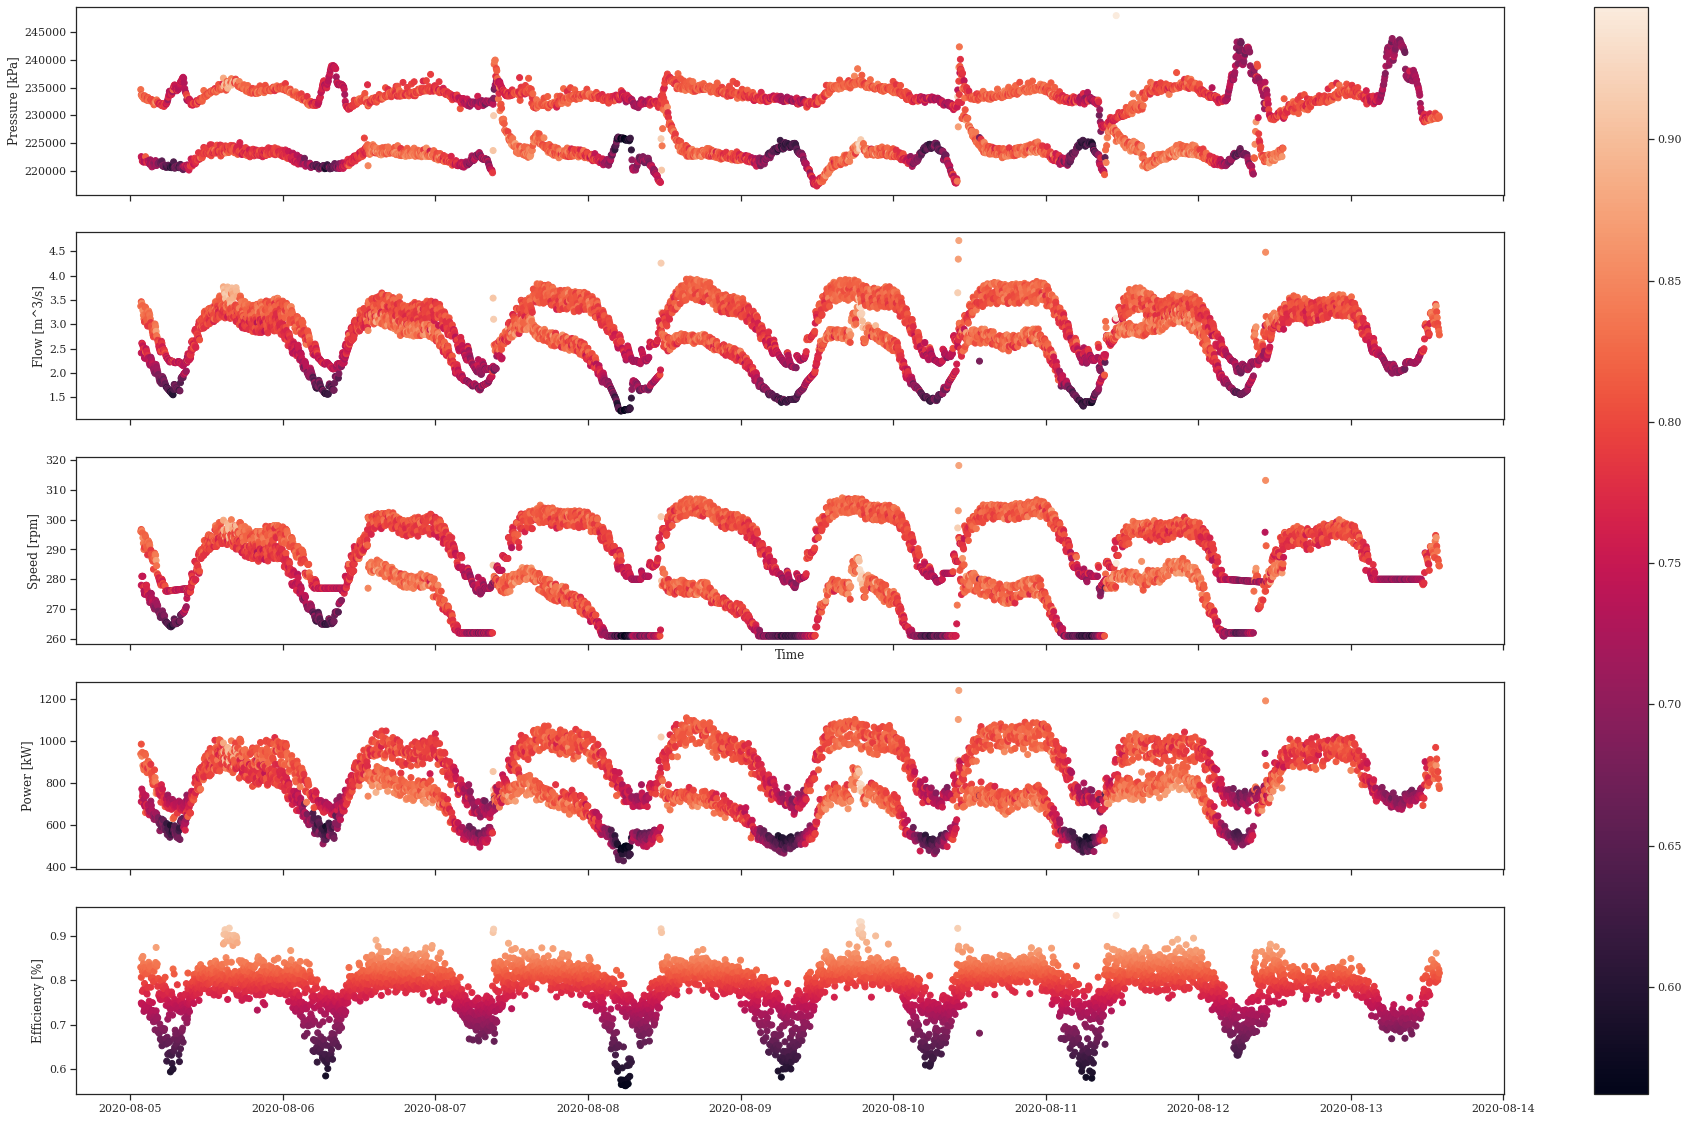

In [ ]:
fig, axs = plt.subplots(5,1, sharex=True, figsize=(32,20))
sc = axs[0].scatter(temp['date'], temp['pressure'], c = temp['calc_eff'])
axs[1].scatter(temp['date'], temp['flow'], c = temp['calc_eff'])
axs[2].scatter(temp['date'], temp['speed'], c = temp['calc_eff'])
axs[3].scatter(temp['date'], temp['power'], c= temp['calc_eff'])
axs[4].scatter(temp['date'], temp['calc_eff'], c = temp['calc_eff'])


fig.colorbar(sc, ax=axs)

axs[2].set_xlabel('Time')
axs[0].set_ylabel('Pressure [kPa]')
axs[1].set_ylabel('Flow [m^3/s]')
axs[2].set_ylabel('Speed [rpm]')
axs[3].set_ylabel('Power [kW]')
axs[4].set_ylabel('Efficiency [%]')

plt.show()

In [ ]:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 44}

plt.rc('font', **font)

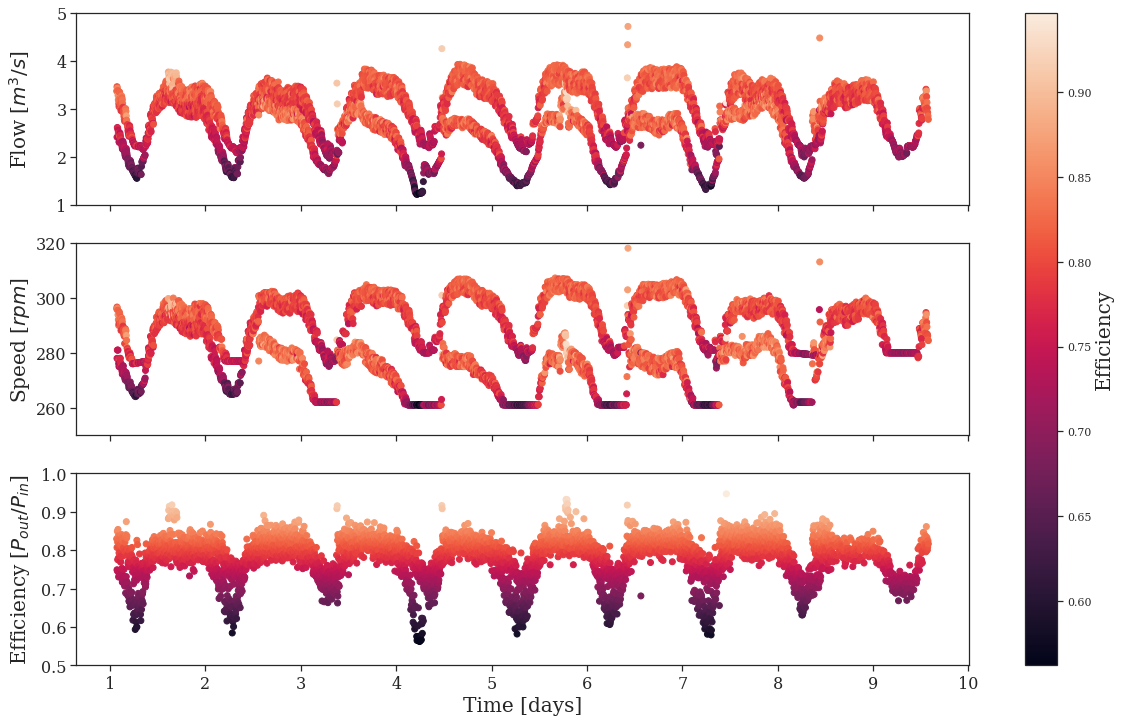

In [ ]:
# Paper Figure 3
fs = 20
fig, axs = plt.subplots(3,1, sharex=True, figsize=(20,12))
sc = axs[0].scatter(temp['date'], temp['flow'], c = temp['calc_eff'])
axs[1].scatter(temp['date'], temp['speed'], c = temp['calc_eff'])
axs[2].scatter(temp['date'], temp['calc_eff'], c = temp['calc_eff'])

cb = plt.colorbar(sc, ax=axs)
cb.set_label(label='Efficiency', fontsize=fs)

axs[2].set_xlabel('Time [days]', fontsize=fs)
axs[0].set_ylabel('Flow [$m^3/s$]', fontsize=fs)
axs[1].set_ylabel('Speed [$rpm$]', fontsize=fs)
axs[2].set_ylabel('Efficiency [$P_{out}/P_{in}$]', fontsize=fs)

for i in range(0,3):
  axs[i].tick_params(labelsize=16)
labels = np.arange(1,11,1)
axs[2].set_xticklabels(labels)

axs[0].set_ylim(1,5)
axs[1].set_ylim(250,320)
axs[2].set_ylim(0.5,1)

fig.align_ylabels(axs[:])
#axs.set_yticklabels(fontsize=14)
#sc.axs.tick_params(labelsize='large')

plt.show()

In [ ]:
sort = p5min.sort_values(by='time')
sort = sort[sort['calc_eff']>0.55]
sort = sort[sort['pump']==7]
temp = sort.iloc[4000:8000]

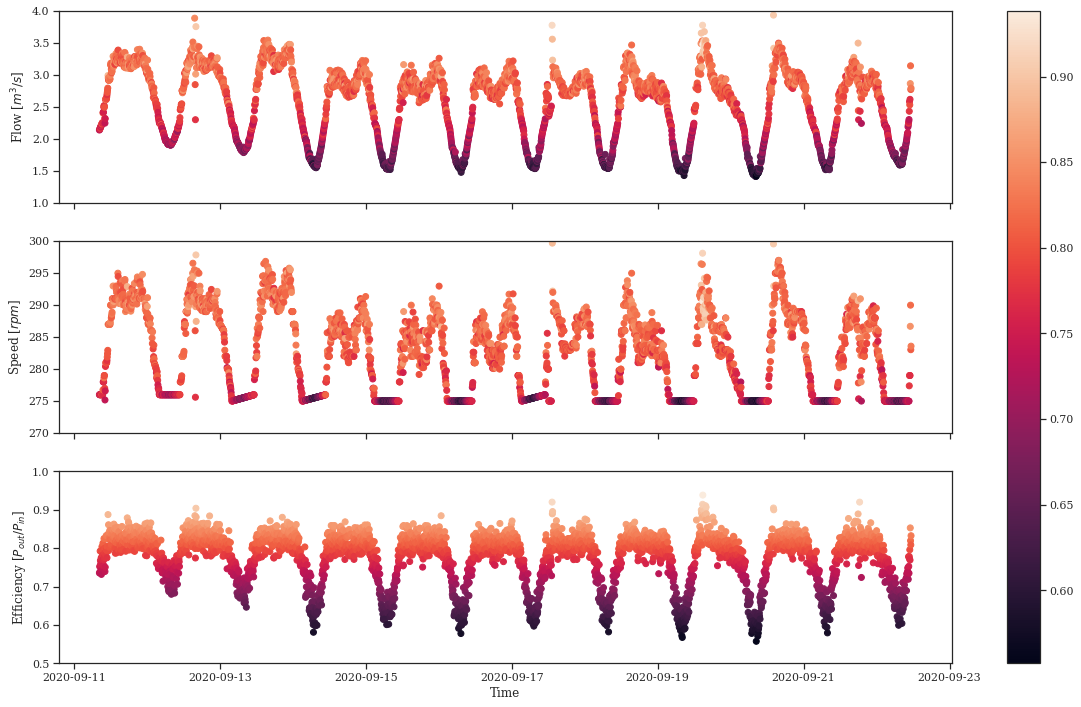

In [ ]:
fig, axs = plt.subplots(3,1, sharex=True, figsize=(20,12))
sc = axs[0].scatter(temp['date'], temp['flow'], c = temp['calc_eff'])
axs[1].scatter(temp['date'], temp['speed'], c = temp['calc_eff'])
axs[2].scatter(temp['date'], temp['calc_eff'], c = temp['calc_eff'])

fig.colorbar(sc, ax=axs)

axs[2].set_xlabel('Time')
axs[0].set_ylabel('Flow [$m^3/s$]')
axs[1].set_ylabel('Speed [$rpm$]')
axs[2].set_ylabel('Efficiency [$P_{out}/P_{in}$]')
axs[0].set_ylim(1,4)
axs[1].set_ylim(270,300)
axs[2].set_ylim(0.5,1)

plt.show()

# Fast fourier transform FFT

Calculate the fast fourier transform of the datapoints to evaluate in the frequency domain.

In [ ]:
import scipy as sp
from scipy.fft import fft, fftfreq

In [ ]:
samples = pump['power'].values
# want just the values not the dataframe

In [ ]:
top = np.max(samples)
bottom = np.min(samples)
mid = np.average(samples)
normSamples = (samples - mid)
normSamples /= top - bottom

In [ ]:
# Ref: https://ipython-books.github.io/101-analyzing-the-frequency-components-of-a-signal-with-a-fast-fourier-transform/
pwr_fft = fft(normSamples)
pwr_psd = np.abs(pwr_fft)**2
print(pwr_psd.shape)
sample_freq = fftfreq(n=pwr_psd.size, d=1./(24))
i = sample_freq > 0


(20051,)


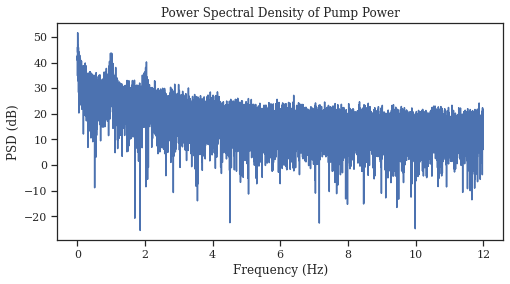

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(sample_freq[i], 10 * np.log10(pwr_psd[i]))
#ax.set_xlim(0, 12)
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('PSD (dB)')
ax.set_title('Power Spectral Density of Pump Power')
plt.show()

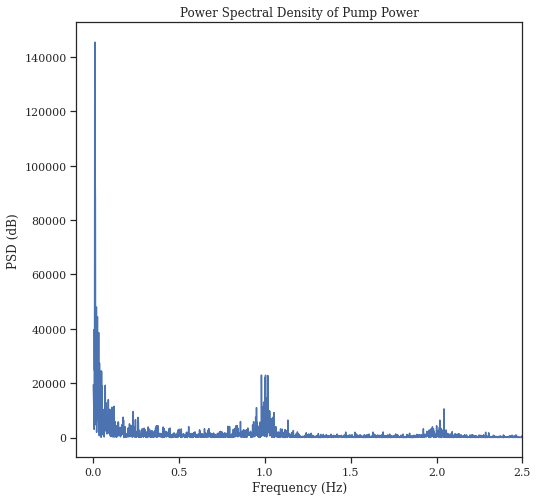

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(sample_freq[i], pwr_psd[i])
ax.set_xlim(-0.1, 2.5)
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('PSD (dB)')
ax.set_title('Power Spectral Density of Pump Power')
plt.show()

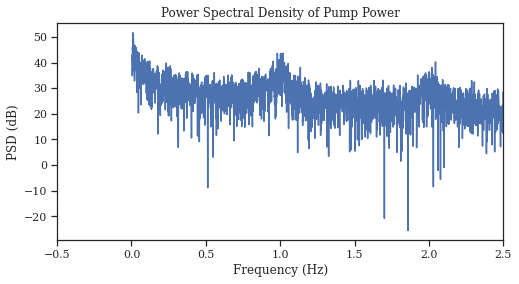

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(sample_freq[i], 10 * np.log10(pwr_psd[i]))
ax.set_xlim(-0.5, 2.5)
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('PSD (dB)')
ax.set_title('Power Spectral Density of Pump Power')
plt.show()

In [ ]:
from matplotlib import pyplot

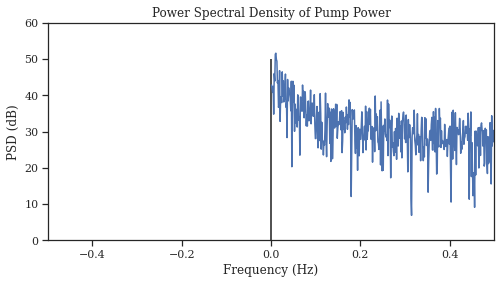

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(sample_freq[i], 10 * np.log10(pwr_psd[i]))
pyplot.vlines(0, ymin = 0, ymax = 50)
ax.set_xlim(-0.5, 0.5)
ax.set_ylim(0, 60)
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('PSD (dB)')
ax.set_title('Power Spectral Density of Pump Power')
plt.show()

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0, 0.5, 'FFT (units=dB?)')

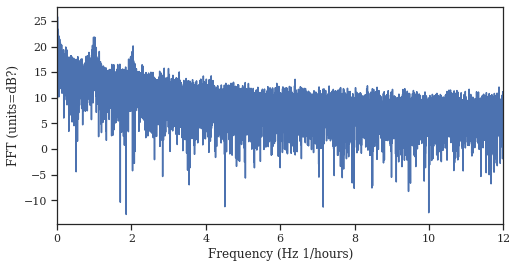

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(sample_freq[i], 10 * np.log10(pwr_fft[i]))
ax.set_xlim(0, 12)
ax.set_xlabel('Frequency (Hz 1/hours)')
ax.set_ylabel('FFT (units=dB?)')

# Pump operation

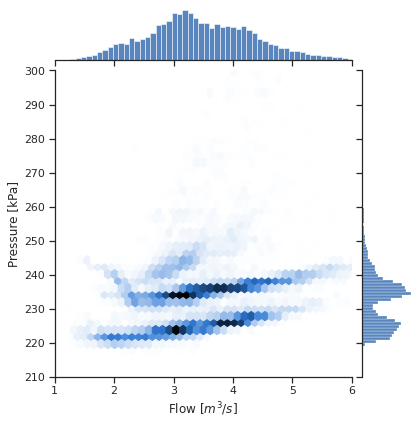

In [28]:
#sns.set(style='ticks', font='serif', font_scale=1.2)
g = sns.jointplot(x = pump['flow'], y = pump['pressure']/1000,  kind="hex", color='#225ea8', xlim=(1,6), ylim=(210, 300))
g.set_axis_labels('Flow [$m^3/s$]','Pressure [kPa]')


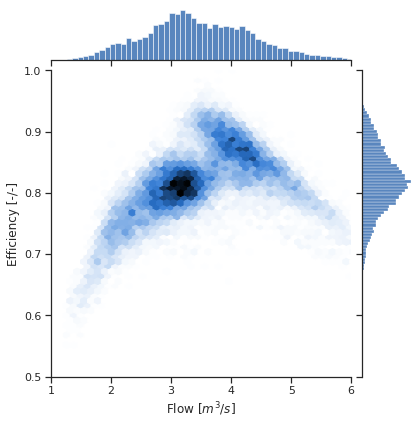

In [29]:
g1 = sns.jointplot(x = 'flow', y = 'calc_eff', data = pump, kind="hex", color='#225ea8', xlim=(1,6), ylim=(0.5, 1))
g1.set_axis_labels('Flow [$m^3/s$]','Efficiency [-/-]')

#plt.xlabel('Pumps', fontsize=20)
#plt.ylabel('Flow [m^3/s]', fontsize=20)

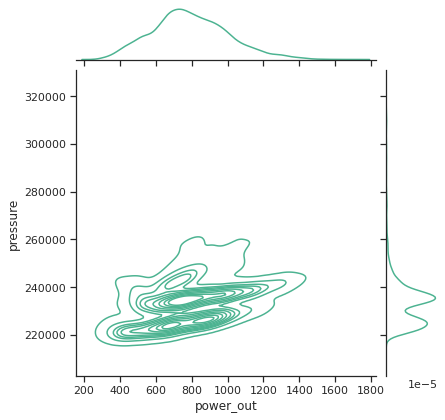

In [30]:
sns.set(style="ticks")
sns.jointplot(x = 'power_out', y = 'pressure', data = pump, kind="kde", color="#4CB391", height=6, ratio = 5)

# Operating space analysis



In [ ]:
# Need to install the plotly libary
#!pip install cufflinks plotly
import plotly.express as px

In [ ]:
fig = px.scatter_3d(pump, x='flow', y='speed', z='pressure',
                    color='calc_eff')
# can also do p5min
fig.show()

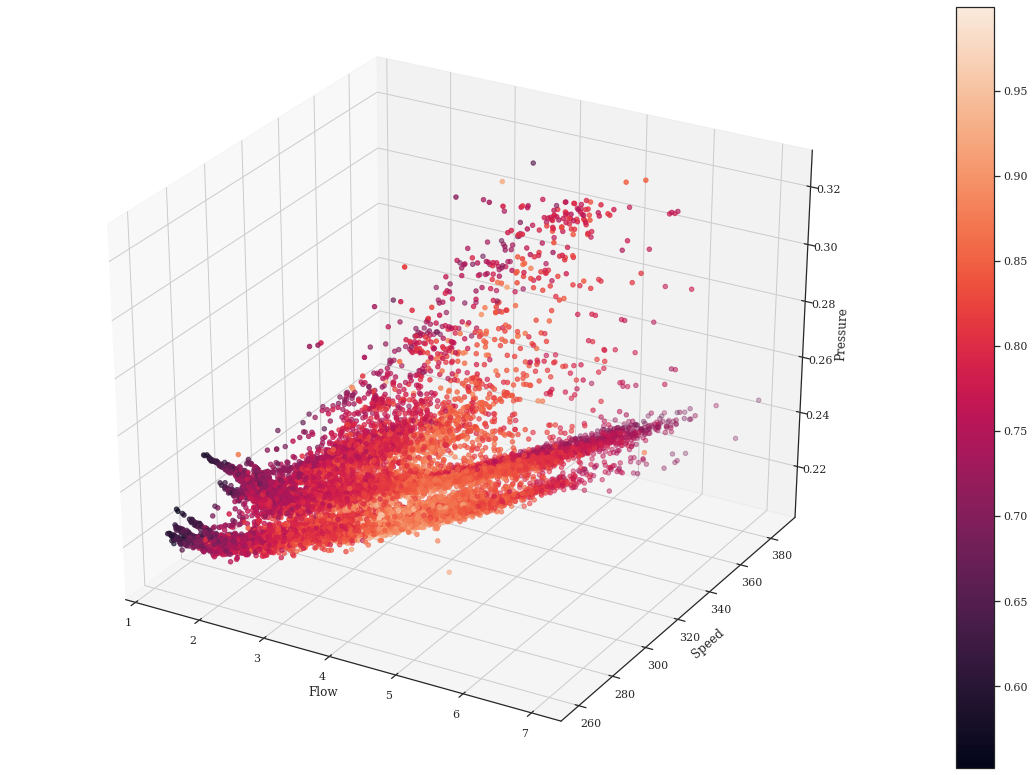

In [ ]:
Z = pump['speed']
X = pump['flow']
Y = pump['pressure']

fig = plt.figure(figsize = (20, 14))

ax = plt.axes(projection="3d")
sc = ax.scatter(X, Z, Y/1000000, c=pump['calc_eff'])
cbar=plt.colorbar(sc)
ax.set_xlabel('Flow')
ax.set_ylabel('Speed')
ax.set_zlabel('Pressure')

plt.show()

In [ ]:
# Could normalize data with dimensionless flow, head & speed coefficients (Gulich table 3.4)
data = pump[['flow', 'pressure', 'speed']]
data['flow'] = data['flow']/max(data['flow'])
data['pressure'] = data['pressure']/max(data['pressure'])
data['speed'] = data['speed']/max(data['speed'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



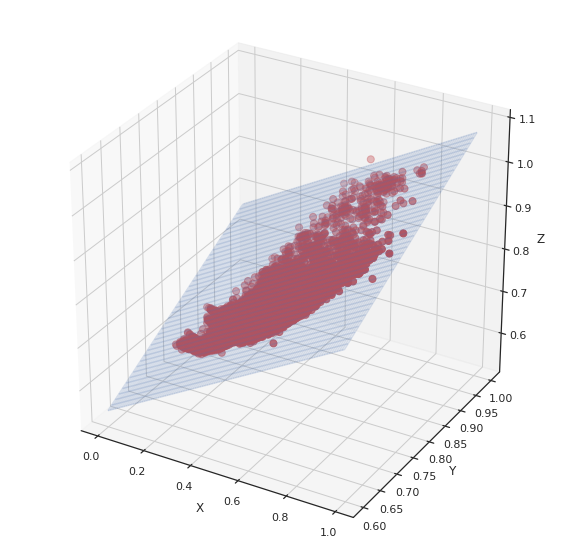

In [ ]:
#import numpy as np
#import matplotlib.pyplot as plt
import scipy.linalg
from mpl_toolkits.mplot3d import Axes3D

# regular grid covering the domain of the data
X,Y = np.meshgrid(np.arange(0, 1, 0.01), np.arange(0.6, 1, 0.01))
XX = X.flatten()
YY = Y.flatten()

order = 1    # 1: linear, 2: quadratic
if order == 1:
    # best-fit linear plane
    A = np.c_[data.iloc[:,0], data.iloc[:,1], np.ones(data.shape[0])]
    C,r,_,_ = scipy.linalg.lstsq(A, data.iloc[:,2])    # coefficients
    
    # evaluate it on grid
    Z = C[0]*X + C[1]*Y + C[2]
    
    # or expressed using matrix/vector product
    #Z = np.dot(np.c_[XX, YY, np.ones(XX.shape)], C).reshape(X.shape)

elif order == 2:
    # best-fit quadratic curve
    A = np.c_[np.ones(data.shape[0]), data.iloc[:,:2], np.prod(data.iloc[:,:2], axis=1), data.iloc[:,:2]**2]
    C,r,_,_ = scipy.linalg.lstsq(A, data.iloc[:,2])
    
    # evaluate it on a grid
    Z = np.dot(np.c_[np.ones(XX.shape), XX, YY, XX*YY, XX**2, YY**2], C).reshape(X.shape)

# plot points and fitted surface
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')
ax.plot_wireframe(X, Y, Z, rstride=1, cstride=1, alpha=0.2)
ax.scatter(data.iloc[:,0], data.iloc[:,1], data.iloc[:,2], c='r', s=50)
plt.xlabel('X')
plt.ylabel('Y')
ax.set_zlabel('Z')
#ax.axis('equal')
ax.axis('tight')
plt.show()

This section of code fits a plane to the data points. Below are the coefficients c1, c2, c3 for the plane equztion and the residual.

For a linear plane fit the residual is   :     0.00017 \\
For a quadratic plane fit the residual is :     0.0000697 \\


Next, find the new axes for this plane, a coordinate transform and then plot the efficiency islands on it.


In [ ]:
print(C)
print(r/len(data['flow']))

[0.3093906  0.58370413 0.19423541]
0.00010175209710704044


In [ ]:
data = pump[['flow', 'pressure', 'speed', 'power']]
data['flow'] = data['flow']/max(data['flow'])
data['pressure'] = data['pressure']/max(data['pressure'])
data['speed'] = data['speed']/max(data['speed'])
data['power'] = data['power']/max(data['power'])

In [ ]:
print(min(pump['speed']))
print(min(data['speed']))

259.0
0.6694202549092314


In [ ]:
# Calculate power plane
X,Y,Z = np.meshgrid(np.arange(0, 1, 0.01), np.arange(0.6, 1, 0.01), np.arange(0, 1, 0.01))
XX = X.flatten()
YY = Y.flatten()
ZZ = Z.flatten()

A = np.c_[data.iloc[:,0], data.iloc[:,1], data.iloc[:,2], np.ones(data.shape[0])]
H,r,_,_ = scipy.linalg.lstsq(A, data.iloc[:,3])    # coefficients
print(H, r/len(pump['flow']))

W = H[0]*X + H[1]*Y + H[2]*Z + H[3] # equation for power as a function of flow, pressure and speed

[ 0.11691394 -0.21075093  1.91154946 -0.96504914] 0.0002048320359617948


In [ ]:
# Using the equations determined above, calculate a plot of flow Q for the two speeds omega A & omega B
G = [1/C[0], -C[1]/C[0], -C[2]/C[0]]
print('G the coefficients for flow are', G)

# Define omegaA and omegaB the two ranges of speed we'll compute this over
omegaA, omegaB = np.meshgrid(np.arange(0.67, 1, 0.001), np.arange(0.67, 1, 0.001))
AA = omegaA.flatten()
BB = omegaB.flatten()

# Define the set pressure for the system
P = np.mean(data.iloc[:,1])
print('The pressure P is ', P)

# The combined flow Qt
Qt = G[0]*(omegaA + omegaB) + 2*G[1]*P + 2*G[2]

# Combined power Wt
Wt = (G[0]*H[0]+H[2])*(omegaA + omegaB) + P*2*(H[0]*G[1]+H[1])+2*(H[0]*G[2]+H[3])

# Efficiency
Et = (Qt*P)/Wt


G the coefficients for flow are [3.2321602480435168, -1.886625281771774, -0.6277999571009877]
The pressure P is  0.7213790940075708


# Quadratic Total Flow, Power Efficiency

In [34]:
import matplotlib.tri as mtri
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
from matplotlib import cm

In [ ]:
data = pump[['speed', 'pressure', 'flow', 'power']]

pwrnorm = max(data['power'])
snorm = max(data['speed'])
fnorm = max(data['flow'])
pnorm = max(data['pressure'])      


data['flow'] = data['flow']/max(data['flow'])
data['pressure'] = data['pressure']/max(data['pressure'])
data['speed'] = data['speed']/max(data['speed'])
data['power'] = data['power']/max(data['power'])

P = np.mean(data.iloc[:,1])


In [36]:
# regular grid covering the domain of the data

X,Y = np.meshgrid(np.arange(0.7, 1, 0.005), np.arange(0.6, 1, 0.005))
XX, YY = X.flatten(), Y.flatten()

# best-fit quadratic curve
A = np.c_[np.ones(data.shape[0]), data.iloc[:,:2], np.prod(data.iloc[:,:2], axis=1), data.iloc[:,:2]**2]
C,r,_,_ = scipy.linalg.lstsq(A, data.iloc[:,2])
    
# evaluate it on a grid
Z = np.dot(np.c_[np.ones(XX.shape), XX, YY, XX*YY, XX**2, YY**2], C).reshape(X.shape)


# create system plane
M,N = np.meshgrid(np.arange(0, 1, 0.01), np.arange(0.7, 1, 0.01))
MM, NN = M.flatten(), N.flatten()
PP = np.ones((31,100))*P


In [37]:
print(C)

[-0.37942117  7.80555305 -7.27090982  6.40822911 -5.96349589  0.18864433]


In [38]:
U,V = np.meshgrid(np.arange(0.7, 1, 0.005), np.arange(0.6, 1, 0.005))
UU, VV = U.flatten(), V.flatten()

Qa = C[0] + C[1]*UU + C[2]*P + C[3]*UU*P + C[4]*UU**2 + C[5]*P**2
Qa.shape

(4880,)

In [ ]:
# plot points and fitted surface
#fig = plt.figure(figsize = (15,15))
#ax = fig.gca(projection='3d')

# flow = z, speed = x, pressure = y
#ax.plot_surface(Z, X, Y, color='blue', alpha=0.4, linewidth=0)
#ax.plot_surface(M, N, PP, color='red', alpha=0.4, linewidth=0)

#ax.plot_wireframe(Z, X, Y, rstride=1, cstride=1, alpha=0.2)
#ax.plot_wireframe(M, N, PP, rstride=1, cstride=1, alpha=0.2)


#ax.scatter(data.iloc[:,2], data.iloc[:,0], data.iloc[:,1], c='r', s=50)
#plt.xlabel('Flow')
#plt.ylabel('Speed')
#ax.set_zlabel('Pressure')
#ax.axis('tight')

#ax.scatter(Qa, UU, P)

#ax.axes.set_xlim3d(left=0, right=1) 
#ax.axes.set_ylim3d(bottom=0.7, top=1) 
#ax.axes.set_zlim3d(bottom=0.6, top=1) 

#angle = -70
#ax.view_init(40, angle)

#plt.show()


# contour projection reference https://matplotlib.org/3.1.0/gallery/mplot3d/contour3d_3.html


In [39]:
print(C)
print(r/len(data['flow']))


[-0.37942117  7.80555305 -7.27090982  6.40822911 -5.96349589  0.18864433]
0.0007123012557889096


In [41]:
# Select columns from pump dataframe
data = pump[['speed', 'pressure', 'flow', 'power']]

pwrnorm = max(data['power'])
snorm = max(data['speed'])
fnorm = max(data['flow'])
pnorm = max(data['pressure'])      

data['flow'] = data['flow']/max(data['flow'])
data['pressure'] = data['pressure']/max(data['pressure'])
data['speed'] = data['speed']/max(data['speed'])
data['power'] = data['power']/max(data['power'])
#pump.head()

print(min(pump['speed']))
print(min(data['speed']))

259.0
0.6694202549092314


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [43]:
# Calculate power plane: speed, pressure and flow
X,Y,Z = np.meshgrid(np.arange(0, 1, 0.01), np.arange(0.6, 1, 0.01), np.arange(0, 1, 0.01))
XX = X.flatten()
YY = Y.flatten()
ZZ = Z.flatten()

# 1s, X, Y, Z, XY, XZ, YZ, X2, Y2, Z2

A = np.c_[np.ones(data.shape[0]), data.iloc[:,:3], np.prod(data.iloc[:,:2], axis=1), np.prod(data.iloc[:, [0, 2]], axis=1), np.prod(data.iloc[:, [1, 2]], axis=1), data.iloc[:,:3]**2]
H,r,_,_ = scipy.linalg.lstsq(A, data.iloc[:,3])
print('Coefficients ', H)
print('Residual ', r/len(pump['flow']))
print('A shape ', A.shape)
print('A       ', A[0,:])

Coefficients  [ 0.03577453  2.07271644 -1.68795434 -1.74642341  9.31377346  7.74357967
 -3.478706   -7.27412545 -2.5986195  -1.47132754]
Residual  9.501225722782844e-05
A shape  (20051, 10)
A        [1.         0.78055953 0.70869428 0.56820316 0.55317807 0.44351639
 0.40268233 0.60927317 0.50224759 0.32285483]


In [44]:
# evaluate it on a grid
Z = np.dot(np.c_[np.ones(XX.shape), XX, YY, ZZ, XX*YY, XX*ZZ, YY*ZZ, XX**2, YY**2, ZZ**2], H).reshape(X.shape)
# equation for power as a function of flow, pressure and speed, derived
W =  H[0]*1 +H[1]*XX + H[2]*YY + H[3]*ZZ + H[4]*XX*YY + H[5]*XX*ZZ + H[6]*YY*ZZ + H[7]*XX**2 + H[8]*YY**2 + H[9]*ZZ**2 

In [45]:
# Define omegaA and omegaB the two ranges of speed we'll compute this over
omegaA, omegaB = np.meshgrid(np.arange(0.67, 1, 0.001), np.arange(0.67, 1, 0.001))
AA = omegaA.flatten()
BB = omegaB.flatten()

# Define the set pressure for the system (P = P0 + sQ)
P = np.mean(data.iloc[:,1])
print('The pressure P is ', P)

Qa = C[0] + C[1]*omegaA + C[2]*P + C[3]*omegaA*P + C[4]*omegaA**2 + C[5]*P**2
Qb = C[0] + C[1]*omegaB + C[2]*P + C[3]*omegaB*P + C[4]*omegaB**2 + C[5]*P**2

# The combined flow Qt
Qt = Qa + Qb

# Combined power Wt
Wt = 2*H[0]+(omegaA+omegaB)*(H[1]+H[4]*P) + 2*H[2]*P + 2*H[8]*P**2 + (Qa+Qb)*(H[3]+H[6]*P) + H[5]*(omegaA*Qa + omegaB*Qb) + H[7]*(omegaA**2 + omegaB**2) + H[9]*(Qa**2+Qb**2)


The pressure P is  0.7213790940075708


In [46]:
# Unnormalize values
P = P*pnorm
Qt = Qt*fnorm
Wt = Wt*pwrnorm
omegaA = omegaA*snorm
omegaB = omegaB*snorm
print('P ', P, 'Qt ', Qt[1,1], 'Wt ', Wt[1,1])
print(Qt.shape)

P  233856.56150556053 Qt  1.7953689853931931 Wt  882.8000342314393
(330, 330)


In [47]:
# Efficiency
Et = (Qt*P)/(Wt*1000)

In [48]:
# Find the best speed based on the max efficiency
ymax = np.amax(Et)
print('Max efficiency ', ymax)
max_index = np.where(Et == np.amax(Et))
print('Max index ', max_index)
omax = omegaA[128,128]
Qmax = Qt[128,128]
print('BEP speed', omax, 'BEP eff', ymax, 'BEP flow', Qmax/2)

Max efficiency  0.8683242599405585
Max index  (array([130]), array([130]))
BEP speed 308.74775372314457 BEP eff 0.8683242599405585 BEP flow 4.163233685175384


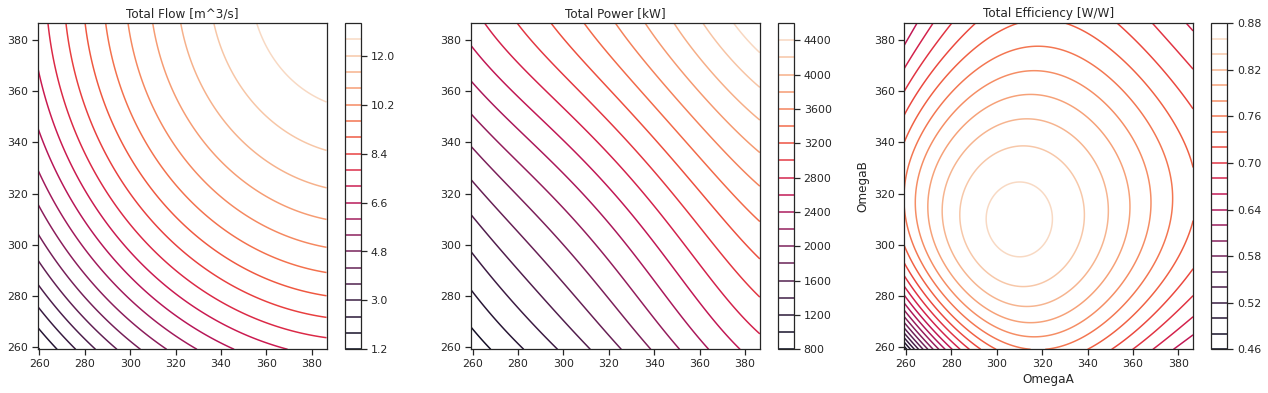

In [50]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(22,6))
#ax.plot_wireframe(omegaA, omegaB, rstride=1, cstride=1, alpha=0.2)
#sc1 = ax1.scatter(omegaA, omegaB, c=Qt)
sc1 = ax1.contour(omegaA, omegaB, Qt, levels=20)
plt.colorbar(sc1, ax=ax1)
ax1.set_title('Total Flow [m^3/s]')

sc2 = ax2.contour(omegaA, omegaB, Wt, levels=20)
#sc2 = ax2.scatter(omegaA, omegaB, c=Wt)
plt.colorbar(sc2, ax=ax2)
ax2.set_title('Total Power [kW]')

sc3 = ax3.contour(omegaA, omegaB, Et, levels=20)
#sc3 = ax3.scatter(omegaA, omegaB, c=Et)
plt.colorbar(sc3, ax=ax3)
ax3.set_title('Total Efficiency [W/W]')

plt.xlabel('OmegaA')
plt.ylabel('OmegaB')

plt.show()

In [ ]:
from matplotlib.font_manager import FontProperties

font = FontProperties()
font.set_family('serif')
font.set_name('Times New Roman')

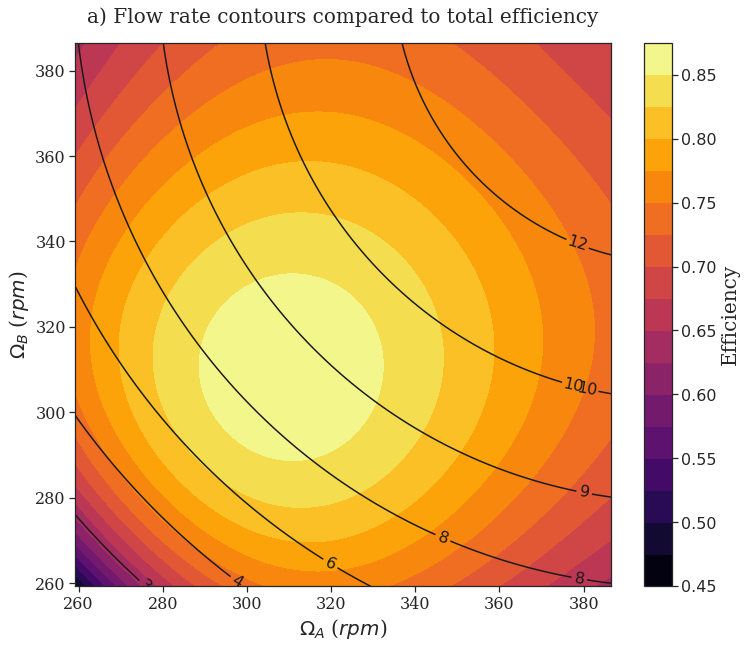

In [52]:
# Overlay flow isolines on the efficiency countour plot
fig, ax = plt.subplots(figsize=(12,10))
cs1 = ax.contour(omegaA, omegaB, Qt, levels=10, colors='k')

manual_locations = [(380,345), (380,320), (380, 300), (380,280), (380,270), (345, 265), (320, 265), (300, 265), (280, 265)] 
plt.clabel(cs1, inline=1, fontsize=16, manual=manual_locations, fmt='%1.0f')

sc1 = ax.contourf(omegaA, omegaB, Et, cmap=plt.cm.get_cmap('inferno'), levels=16)
norm = mpl.colors.Normalize(vmin=0.58, vmax=1)
cb =  plt.colorbar(sc1, ax=ax, norm=norm)
cb.set_label(label='Efficiency', fontsize=20, fontfamily='serif')
cb.ax.tick_params(labelsize=16)
#cb.ax.set_yticklabels(labels =[0.5, 0.6, 0.7, 0.8, 0.9, 1] ,fontsize=16)
#ax1.set_title('Total Flow [m^3/s] & Total Efficiency [W/W]')
ax.set_title('a) Flow rate contours compared to total efficiency', fontsize=20, fontfamily='serif', pad=20)

plt.xlabel('$\Omega_A$ ($rpm$)', fontsize=20, fontfamily='serif')
plt.xticks(fontsize=16, fontfamily='serif')
plt.ylabel('$\Omega_B$ ($rpm$)', fontsize=20, fontfamily='serif')
plt.yticks(fontsize=16, fontfamily='serif')

plt.show()

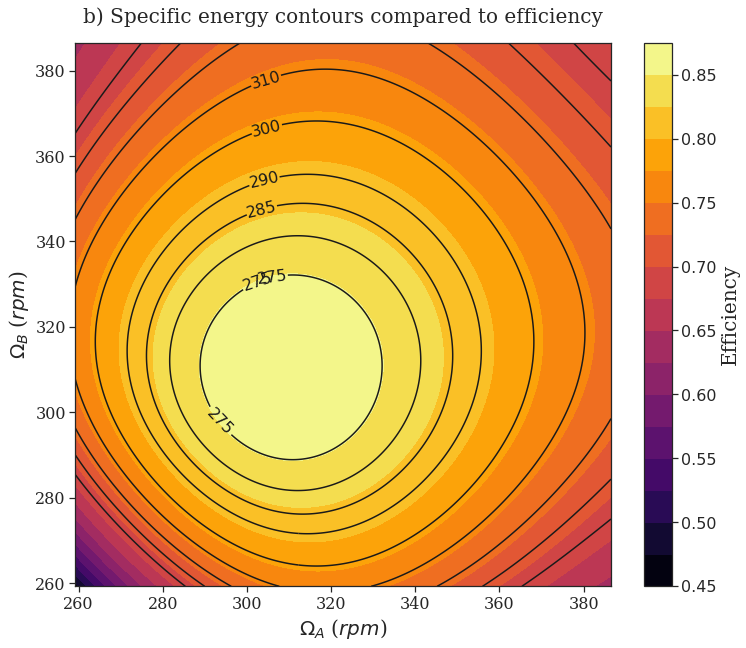

In [54]:
fig, ax = plt.subplots(figsize=(12,10))

levels = [275, 280, 285, 290, 300, 310, 320, 330, 340]
hs = 304
manual_locations = [(hs, 310), (hs, 325), (hs, 335), (hs, 345), (hs, 355), (hs, 370), (hs,380)] 
cs1 = ax.contour(omegaA, omegaB, Wt/Qt, levels=levels,  colors='k')
plt.clabel(cs1, inline=1, fontsize=16, manual=manual_locations, fmt='%1.0f')


plt.contourf(omegaA, omegaB, Et, cmap=plt.cm.get_cmap('inferno'), levels=16)
cb =  plt.colorbar(sc1, ax=ax)
cb.set_label(label='Efficiency', fontsize=20, fontfamily='serif')
cb.ax.tick_params(labelsize=16)

ax.set_title('b) Specific energy contours compared to efficiency', fontsize=20, fontfamily='serif', pad=20)

plt.xlabel('$\Omega_A$ ($rpm$)', fontsize=20, fontfamily='serif')
plt.xticks(fontsize=16, fontfamily='serif')
plt.ylabel('$\Omega_B$ ($rpm$)', fontsize=20, fontfamily='serif')
plt.yticks(fontsize=16, fontfamily='serif')


plt.show()

